fig1E: comparison between fetal and adult by gestation - ?Milo ? UMAP

# Import and settings

In [1]:
%load_ext autoreload
%autoreload 2

import os, re, gc, joblib
import numpy as np
import numpy_groupies as npg
import pandas as pd

import anndata
import scanpy as sc
import sctk as sk

import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
import scipy
from sklearn.preprocessing import minmax_scale
import seaborn as sn

In [3]:
np.set_printoptions(linewidth=150)

rcParams["pdf.fonttype"] = 42
rcParams["ps.fonttype"] = 42

sc.settings.verbosity = 0
sk.set_figsize((4, 4))

In [4]:
from time import localtime, strftime


def timestamp(date_only=True):
    stamp_format = "%Y%m%d" if date_only else "%Y%m%d-%H%M"
    return strftime(stamp_format, localtime())

# Load data

## fetal skin

In [4]:
fetal_ad0 = sc.read("../20210611_final_object/fetal_skin.norm.maternal_removed.20220202.h5ad")

In [5]:
fetal_ad0.shape

(186533, 28885)

what metadata is available in fetal skin?

In [6]:
fetal_ad0.obs.columns

Index(['sanger_id', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample',
       'chemistry_sorting', 'cell_caller', 'scrublet_score',
       'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts',
       'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb',
       'independent_annotation_refined', 'independent_annotation_broad1',
       'independent_annotation_broad2', 'independent_annotation_broad3',
       'independent_annotation_broad4', 'independent_annotation_broad5',
       'joint_annotation', 'is_maternal', 'fig1b_annotation',
       'independent_annotation_refined_20220201a',
       'independent_annotation_refined_20220201b',
       'independent_annotation_broad1_20220201',
       'independent_annotation_broad2_20220201',
       'independent_annotation_broad3_20220201', 'joint_annotation_20220201a',
       'joint_annotation_20220201b', 'fig1b_annotation_20220201',
       'joint_annotation_20220202', 'independent_annotation_refined_20220202',
       'f

What's in "pcw"?

In [7]:
fetal_ad0.obs.pcw.value_counts(dropna=False).sort_index()

7     34565
8     13641
9     15310
10     5231
11    18465
12    13434
13     7211
14    25949
15    46656
16     6071
Name: pcw, dtype: int64

what's in "independent_annotation_broad5"?

In [8]:
fetal_ad0.obs.independent_annotation_broad5.value_counts(dropna=False).sort_index()

Epithelium      2263
Erythroid       3468
Immune         59019
Stroma        121783
Name: independent_annotation_broad5, dtype: int64

what's in "fib1b_annotation"

In [9]:
fetal_ad0.obs.fig1b_annotation_20220202.cat.categories

Index(['Adipocyte', 'B cell', 'Dermal papillia', 'Erythroid', 'Fibroblast',
       'ILC', 'Keratinocyte', 'Langerhans cell', 'Lymphatic endothelium',
       'Macrophage', 'Mast cell', 'Megakaryocyte', 'Melanocyte', 'Monocyte',
       'Mural cell', 'Myofibroblast', 'Neuronal cells', 'Neutrophil',
       'Progenitor', 'Schwann cell', 'Skeletal muscle', 'T cell',
       'Vascular endothelium', 'cDC', 'pDC'],
      dtype='object')

In [10]:
fetal_ad0.obs.fig1b_annotation_20220202.cat.rename_categories(
    {"Neuronal cells": "Neuronal cell"}, inplace=True
)

what's in "joint_annotation"

In [11]:
fetal_ad0.obs.loc[
    fetal_ad0.obs.independent_annotation_broad5 == "Epithelium", "joint_annotation_20220202"
].value_counts().where(lambda x: x > 0).dropna()

Basal                  815.0
Melanocyte             604.0
Matrix/placode         254.0
Melanoblast            190.0
Periderm               153.0
Immature basal          65.0
POSTN+ basal            46.0
Suprabasal IFE          30.0
Companion layer         27.0
Outer root sheath       25.0
Cuticle/cortex          21.0
Inner root sheath       18.0
Immature suprabasal     15.0
Name: joint_annotation_20220202, dtype: float64

what type of data is in "X"?

In [12]:
fetal_ad0.X.data

array([1.8038048, 1.4774609, 1.4774609, ..., 1.6299081, 2.2199435, 2.8572528], dtype=float32)

In [13]:
np.expm1(
    fetal_ad0.X[
        0:5,
    ]
).sum(axis=1)

matrix([[10005.071],
        [10006.827],
        [10006.456],
        [10006.766],
        [10001.346]], dtype=float32)

ok, seems it's log1p-transformed normalised values

## adult skin

In [14]:
adult_ad0 = sc.read("../data/h5ad/Healthy_all_data.h5ad")

In [15]:
adult_ad0.shape

(217266, 33538)

In [16]:
adult_ad0

AnnData object with n_obs × n_vars = 217266 × 33538
    obs: 'sample_id', 'mad_prd', 'Status', 'Site', 'Site_old', 'Tissue', 'Enrichment', 'Location', 'donor_id', 'Sex', 'Age', 'stage', 'anno_final', 'final'
    var: 'gene_ids-SKN8090524', 'feature_types-SKN8090524', 'gene_ids-SKN8090525', 'feature_types-SKN8090525', 'gene_ids-SKN8090526', 'feature_types-SKN8090526', 'gene_ids-SKN8090527', 'feature_types-SKN8090527', 'gene_ids-SKN8090528', 'feature_types-SKN8090528', 'gene_ids-SKN8090529', 'feature_types-SKN8090529', 'gene_ids-SKN8090530', 'feature_types-SKN8090530', 'gene_ids-SKN8090531', 'feature_types-SKN8090531', 'gene_ids-SKN8090536', 'feature_types-SKN8090536', 'gene_ids-SKN8090537', 'feature_types-SKN8090537', 'gene_ids-SKN8090538', 'feature_types-SKN8090538', 'gene_ids-SKN8090539', 'feature_types-SKN8090539', 'gene_ids-SKN8090540', 'feature_types-SKN8090540', 'gene_ids-SKN8090541', 'feature_types-SKN8090541', 'gene_ids-SKN8090542', 'feature_types-SKN8090542', 'gene_ids-SKN80905

In [17]:
adult_ad0.var = adult_ad0.var[["gene_ids-SKN8090524", "feature_types-SKN8090524"]].rename(
    columns={"gene_ids-SKN8090524": "gene_ids", "feature_types-SKN8090524": "feature_types"}
)

In [18]:
sk.calculate_qc(adult_ad0)

what metadata is available in adult skin?

In [19]:
adult_ad0.obs.columns

Index(['sample_id', 'mad_prd', 'Status', 'Site', 'Site_old', 'Tissue',
       'Enrichment', 'Location', 'donor_id', 'Sex', 'Age', 'stage',
       'anno_final', 'final', 'n_counts', 'log1p_n_counts', 'n_genes',
       'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo',
       'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50'],
      dtype='object')

what's in "Age"?

In [20]:
adult_ad0.obs.Age.value_counts(dropna=False)

NaN    217266
Name: Age, dtype: int64

ok, basically no age information, set them to pcw 999 (40 + 18 * 52 = 976)

In [21]:
adult_ad0.obs["pcw"] = 999

there were some nan in cell type annotation in adult skin?

In [22]:
adult_ad0.obs.anno_final.value_counts(dropna=False).index.sort_values()

CategoricalIndex(['C_Melanocyte', 'DC1', 'DC2', 'F1', 'F2', 'F3', 'ILC1',
                  'ILC1_NK', 'ILC2_3', 'Inf_mono', 'LC_1', 'LC_2', 'LC_3',
                  'LC_4', 'LE1', 'LE2', 'M_A_Mast_cell', 'Macro_1', 'Macro_2',
                  'MigDC', 'Mono', 'NK', 'Pericyte_1_non_inflamm',
                  'Pericyte_2_inflamm', 'Plasma',
                  'Schwaan_1_Stroma_Schwan_myelinating',
                  'Schwaan_2_non_myelinating', 'Tc', 'Th', 'Treg', 'VE1',
                  'VE2', 'VE3', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8',
                  'moDC_1', 'moDC_2', 'moDC_3', 'nan'],
                 categories=['C_Melanocyte', 'DC1', 'DC2', 'F1', 'F2', 'F3', 'ILC1', 'ILC1_NK', ...], ordered=False, dtype='category')

there's indeed nan, let's remove them

In [23]:
adult_ad0 = adult_ad0[adult_ad0.obs.anno_final.astype(str) != "nan"].copy()

make some broad annotations similar to that of fig1b_annotation in fetal skin

In [24]:
adult_ad0.obs["anno_broad"] = sk.regroup(
    adult_ad0,
    groupby="anno_final",
    regroups={
        "ILC": ["ILC1", "ILC1_NK", "ILC2_3", "NK"],
        "T cell": ["Tc", "Th", "Treg"],
        "Plasma cell": ["Plasma"],
        "Monocyte": ["Inf_mono", "Mono"],
        "Macrophage": ["Macro_1", "Macro_2"],
        "cDC": ["DC1", "DC2", "MigDC", "moDC_1", "moDC_2", "moDC_3"],
        "Langerhans cell": ["LC_1", "LC_2", "LC_3", "LC_4"],
        "Mast cell": ["M_A_Mast_cell"],
        "Fibroblast": ["F1", "F2", "F3"],
        "Pericyte": ["Pericyte_1_non_inflamm", "Pericyte_2_inflamm"],
        "Keratinocyte": ["c1", "c2", "c3", "c4", "c5", "c6", "c7", "c8"],
        "Melanocyte": ["C_Melanocyte"],
        "Lymphatic endothelium": ["LE1", "LE2"],
        "Vascular endothelium": ["VE1", "VE2", "VE3"],
        "Schwann cell": ["Schwaan_1_Stroma_Schwan_myelinating", "Schwaan_2_non_myelinating"],
    },
)

In [25]:
adult_ad0.obs.anno_broad.value_counts(dropna=False).index

CategoricalIndex(['Keratinocyte', 'T cell', 'Vascular endothelium',
                  'Fibroblast', 'cDC', 'Langerhans cell', 'Macrophage', 'ILC',
                  'Monocyte', 'Pericyte', 'Lymphatic endothelium',
                  'Melanocyte', 'Mast cell', 'Schwann cell', 'Plasma cell'],
                 categories=['ILC', 'T cell', 'Plasma cell', 'Monocyte', 'Macrophage', 'cDC', 'Langerhans cell', 'Mast cell', ...], ordered=False, dtype='category')

what type of data is in "X"?

In [26]:
adult_ad0.X.data

array([6., 2., 3., ..., 1., 2., 1.], dtype=float32)

ok, seems it's raw counts

## skin organoid

In [27]:
organoid_ad0 = sc.read("../data/h5ad/organoid_day13_29_48_85_133.cellxgene.h5ad")

In [28]:
organoid_ad0.shape

(123835, 38072)

what metadata is available in organoid data?

In [29]:
organoid_ad0.obs.columns

Index(['day', 'sample_id', 'strain', 'version', 'week', 'nh3_annot1',
       'n_counts', 'log1p_n_counts', 'n_genes', 'log1p_n_genes',
       'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo',
       'percent_hb', 'n_counts_hb', 'percent_top50', 'pass_auto_filter',
       'scrublet_score', 'scrublet_score_z', 'cluster_scrublet_score',
       'bh_pval', 'scrublet_done', 'doublet', 'seurat_clusters',
       'fsk_annot1_min30', 'fsk_annot1_min30_prob', 'fsk_annot2_min30',
       'fsk_annot2_min30_prob', 'day8to13', 'org_annot0', 'org_annot0_prob',
       'org_annot30', 'org_annot30_prob', 'fsk_annot0', 'fsk_annot0_prob',
       'fsk_annot30', 'fsk_annot30_prob'],
      dtype='object')

what's in "day"?

In [30]:
organoid_ad0.obs.day.value_counts(dropna=False).sort_index()

day-13      9557
day-29     16176
day-48     18898
day-85     15948
day-133    63256
Name: day, dtype: int64

what's in "week"?

In [31]:
organoid_ad0.obs.week.value_counts(dropna=False).sort_index()

4-7_fetal_wks      16176
7-10_fetal_wks     18898
14-16_fetal_wks    15948
17-20_fetal_wks    63256
nan                 9557
Name: week, dtype: int64

Set "pcw" from "day"

In [32]:
organoid_ad0.obs["pcw"] = (
    (organoid_ad0.obs.day.str.replace("day-", "").astype(int) / 7).round().astype(int)
)

what's in "strain"?

In [33]:
organoid_ad0.obs.strain.value_counts(dropna=False).sort_index()

DSP     65903
WA25    57932
Name: strain, dtype: int64

what's in "org_annot0"?

In [34]:
organoid_ad0.obs.org_annot0.value_counts(dropna=False).sort_index().index

CategoricalIndex(['organoid_Adipocytes', 'organoid_Basal',
                  'organoid_Basal POSTN+', 'organoid_Basal SHH+',
                  'organoid_Companion layer', 'organoid_Cuticle/cortex',
                  'organoid_Dermal condensate', 'organoid_Dermal papillia',
                  'organoid_Early fibroblasts FRZB+',
                  'organoid_Early fibroblasts HOXC5',
                  'organoid_Early myocytes', 'organoid_Fibroblasts POSTN+',
                  'organoid_Immature basal', 'organoid_Immature suprabasal',
                  'organoid_Inner root sheath', 'organoid_Melanoblasts',
                  'organoid_Melanocytes', 'organoid_Merkel cells',
                  'organoid_Myelinating Schwann cells', 'organoid_Myoblasts',
                  'organoid_Myocytes', 'organoid_Neuroepithelial cells',
                  'organoid_Neuron progenitors',
                  'organoid_Neuron progenitors SPP1+',
                  'organoid_Outer root sheath', 'organoid_Periderm',
 

make some broad annotations similar to that of fig1b_annotation in fetal skin

In [35]:
organoid_ad0.obs["org_annot0_broad"] = sk.regroup(
    organoid_ad0,
    groupby="org_annot0",
    regroups={
        "Adipocyte": ["organoid_Adipocytes"],
        "Dermal papillia": ["organoid_Dermal papillia"],
        "Fibroblast": [
            "organoid_Dermal condensate",
            "organoid_Early fibroblasts FRZB+",
            "organoid_Early fibroblasts HOXC5",
            "organoid_Fibroblasts POSTN+",
            "organoid_Pre-dermal condensate",
        ],
        "Keratinocyte": [
            "organoid_Basal",
            "organoid_Basal POSTN+",
            "organoid_Basal SHH+",
            "organoid_Companion layer",
            "organoid_Cuticle/cortex",
            "organoid_Immature basal",
            "organoid_Immature suprabasal",
            "organoid_Inner root sheath",
            "organoid_Outer root sheath",
            "organoid_Periderm",
            "organoid_Suprabasal IFE",
        ],
        "Melanocyte": [
            "organoid_Melanoblasts",
            "organoid_Proliferating melanoblasts",
            "organoid_Melanocytes",
        ],
        "Skeletal muscle": [
            "organoid_Early myocytes",
            "organoid_Myoblasts",
            "organoid_Myocytes",
        ],
        "Mural cell": ["organoid_Smooth muscle/Pericytes"],
        "Neuronal cell": [
            "organoid_Neuroepithelial cells",
            "organoid_Neuron progenitors",
            "organoid_Neuron progenitors SPP1+",
            "organoid_Secreting neuron",
            "organoid_Merkel cells",
        ],
        "Schwann cell": [
            "organoid_Myelinating Schwann cells",
            "organoid_Schwann cells/Schwann precursors",
        ],
        "Vascular endothelium": ["organoid_Tip cell (arterial)"],
    },
)
organoid_ad0.obs["org_annot0_broad"] = organoid_ad0.obs["org_annot0_broad"].astype("category")

In [36]:
np.expm1(
    organoid_ad0.X[
        0:5,
    ]
).sum(axis=1)

matrix([[ 9999.999],
        [10000.   ],
        [ 9999.999],
        [ 9999.999],
        [ 9999.998]], dtype=float32)

ok, seems it's log1p-transformed normalised values

# Down-sample and pool

In [37]:
fetal_adS = sk.subsample(fetal_ad0, 1, groupby="fig1b_annotation_20220202", min_n=500, max_n=500)

In [38]:
organoid_adS = sk.subsample(organoid_ad0, 1, groupby="org_annot0_broad", min_n=500, max_n=500)

In [39]:
adult_adS = sk.subsample(adult_ad0, 1, groupby="anno_broad", min_n=500, max_n=500)

In [40]:
pooled_adS = sk.integrate(
    [fetal_adS, organoid_adS, adult_adS],
    ad_prefices=["fetal", "organoid", "adult"],
    ad_types=["norm", "norm", "counts"],
    annotations=["fig1b_annotation_20220202", "org_annot0_broad", "anno_broad"],
    batches=["donor", "strain", "donor_id"],
    pool_only=True,
    join="outer",
)

In [41]:
pooled_adS

AnnData object with n_obs × n_vars = 23285 × 46794
    obs: 'sanger_id', 'chemistry', 'batch', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation', 'is_maternal', 'fig1b_annotation', 'independent_annotation_refined_20220201a', 'independent_annotation_refined_20220201b', 'independent_annotation_broad1_20220201', 'independent_annotation_broad2_20220201', 'independent_annotation_broad3_20220201', 'joint_annotation_20220201a', 'joint_annotation_20220201b', 'fig1b_annotation_20220201', 'joint_annotation_20220202', 'independent_annotation_refined_20220202', 'annot', 'day', 'sample_id', 'version', 'week', 'nh3_a

In [42]:
pooled_adS.var["n_counts"] = (
    pooled_adS.var["n_counts-adult"].fillna(0)
    + pooled_adS.var["n_counts-fetal"].fillna(0)
    + pooled_adS.var["n_counts-organoid"].fillna(0)
)

pooled_adS.var["n_cells"] = (
    pooled_adS.var["n_cells-adult"].fillna(0)
    + pooled_adS.var["n_cells-fetal"].fillna(0)
    + pooled_adS.var["n_cells-organoid"].fillna(0)
)

In [43]:
sk.calculate_qc(pooled_adS, flag_only=True)

In [44]:
pooled_adS.var = pooled_adS.var[["mito", "ribo", "hb", "n_counts", "n_cells"]].copy()

In [ ]:
pooled_adS

In [ ]:
pooled_adS.obs.pcw.value_counts(dropna=False).sort_index()

In [50]:
pooled_adS.obs.log2pcw = np.log2(pooled_adS.obs.pcw)

In [ ]:
pooled_adS.obs.batch.value_counts(dropna=False).sort_index()

In [ ]:
pooled_adS.obs.dataset.value_counts(dropna=False).sort_index()

In [ ]:
pooled_adS.obs.annot.value_counts(dropna=False).sort_index()

In [45]:
pooled_adS1 = sk.simple_default_pipeline(
    pooled_adS.copy(),
    post_norm_only=True,
    batch_method="harmony",
    batch=["dataset", "batch"],
    do_clustering=False,
    hvg_kw={"by_batch": ("dataset", 1), "n_hvg": 2000, "subset": True},
    pca_kw={"remove_genes": ["ribo", "mito"]},
)

... storing 'sanger_id' as categorical
... storing 'chemistry' as categorical
... storing 'batch' as categorical
... storing 'gender' as categorical
... storing 'sorting' as categorical
... storing 'sample' as categorical
... storing 'chemistry_sorting' as categorical
... storing 'cell_caller' as categorical
... storing 'independent_annotation_refined' as categorical
... storing 'independent_annotation_broad1' as categorical
... storing 'independent_annotation_broad2' as categorical
... storing 'independent_annotation_broad3' as categorical
... storing 'independent_annotation_broad4' as categorical
... storing 'independent_annotation_broad5' as categorical
... storing 'joint_annotation' as categorical
... storing 'is_maternal' as categorical
... storing 'fig1b_annotation' as categorical
... storing 'independent_annotation_refined_20220201a' as categorical
... storing 'independent_annotation_refined_20220201b' as categorical
... storing 'independent_annotation_broad1_20220201' as catego

In [54]:
pooled_adS1.obs["log2pcw"] = np.log2(pooled_adS1.obs.pcw)
pooled_adS1.obs["log2pcw"] = pooled_adS1.obs["log2pcw"].astype("category")

In [46]:
pooled_adS1

AnnData object with n_obs × n_vars = 23285 × 29897
    obs: 'sanger_id', 'chemistry', 'batch', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation', 'is_maternal', 'fig1b_annotation', 'independent_annotation_refined_20220201a', 'independent_annotation_refined_20220201b', 'independent_annotation_broad1_20220201', 'independent_annotation_broad2_20220201', 'independent_annotation_broad3_20220201', 'joint_annotation_20220201a', 'joint_annotation_20220201b', 'fig1b_annotation_20220201', 'joint_annotation_20220202', 'independent_annotation_refined_20220202', 'annot', 'day', 'sample_id', 'version', 'week', 'nh3_a

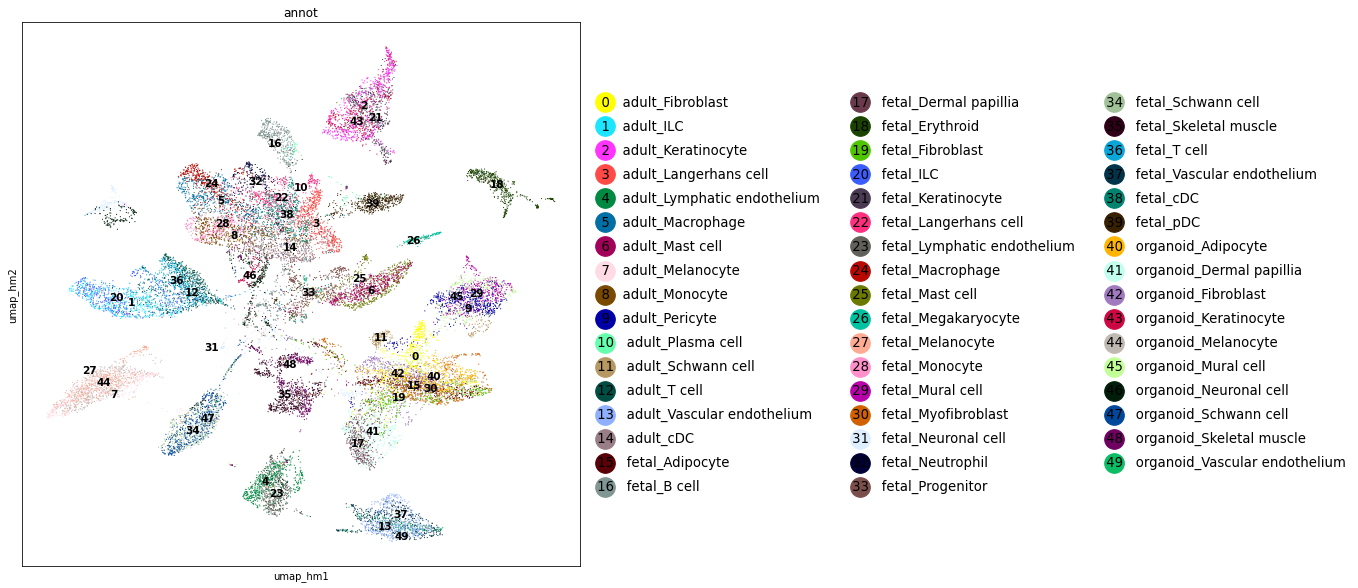

In [47]:
sk.plot_embedding(
    pooled_adS1, basis="umap_hm", groupby="annot", figsize=(10, 10), legend_fontsize=12
);

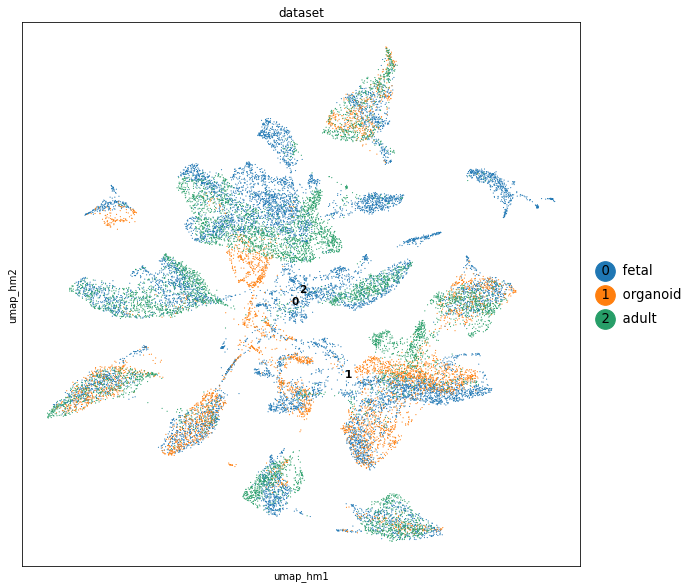

In [48]:
sk.plot_embedding(
    pooled_adS1, basis="umap_hm", groupby="dataset", figsize=(10, 10), legend_fontsize=12
);

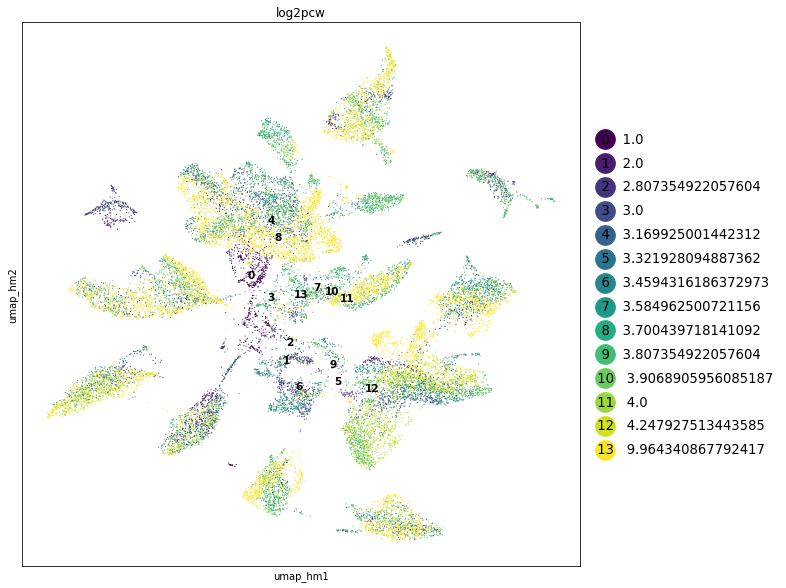

In [58]:
sk.plot_embedding(
    pooled_adS1,
    basis="umap_hm",
    groupby="log2pcw",
    figsize=(10, 10),
    palette="viridis",
    legend_fontsize=12,
);

In [59]:
pooled_adS1.write(
    "pooled_fetal_organoid_adult.downsampled.harmony_integrated.norm.h5ad", compression="lzf"
)

In [4]:
pooled_adS1 = sc.read("pooled_fetal_organoid_adult.downsampled.harmony_integrated.norm.h5ad")

# Pool

pool fetal and adult with the union of genes

In [60]:
pooled_ad0 = sk.integrate(
    [fetal_ad0, organoid_ad0, adult_ad0],
    ad_prefices=["fetal", "organoid", "adult"],
    ad_types=["norm", "norm", "counts"],
    annotations=["fig1b_annotation_20220202", "org_annot0_broad", "anno_broad"],
    batches=["donor", "strain", "donor_id"],
    pool_only=True,
    join="outer",
)

In [61]:
pooled_ad0.var["n_counts"] = (
    pooled_ad0.var["n_counts-adult"].fillna(0)
    + pooled_ad0.var["n_counts-fetal"].fillna(0)
    + pooled_ad0.var["n_counts-organoid"].fillna(0)
)

In [62]:
pooled_ad0.var["n_cells"] = (
    pooled_ad0.var["n_cells-adult"].fillna(0)
    + pooled_ad0.var["n_cells-fetal"].fillna(0)
    + pooled_ad0.var["n_cells-organoid"].fillna(0)
)

In [63]:
sk.calculate_qc(pooled_ad0, flag_only=True)

In [64]:
pooled_ad0.var = pooled_ad0.var[["mito", "ribo", "hb", "n_counts", "n_cells"]].copy()

In [65]:
pooled_ad0.write("pooled_fetal_organoid_adult.norm.h5ad", compression="lzf")

... storing 'sanger_id' as categorical
... storing 'chemistry' as categorical
... storing 'batch' as categorical
... storing 'gender' as categorical
... storing 'sorting' as categorical
... storing 'sample' as categorical
... storing 'chemistry_sorting' as categorical
... storing 'cell_caller' as categorical
... storing 'independent_annotation_refined' as categorical
... storing 'independent_annotation_broad1' as categorical
... storing 'independent_annotation_broad2' as categorical
... storing 'independent_annotation_broad3' as categorical
... storing 'independent_annotation_broad4' as categorical
... storing 'independent_annotation_broad5' as categorical
... storing 'joint_annotation' as categorical
... storing 'is_maternal' as categorical
... storing 'fig1b_annotation' as categorical
... storing 'independent_annotation_refined_20220201a' as categorical
... storing 'independent_annotation_refined_20220201b' as categorical
... storing 'independent_annotation_broad1_20220201' as catego

# Integrate

In [6]:
pooled_ad0 = sc.read("h5ad/pooled_fetal_organoid_adult.norm.h5ad")

In [7]:
pooled_ad0

AnnData object with n_obs × n_vars = 506107 × 46794
    obs: 'sanger_id', 'chemistry', 'batch', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation', 'is_maternal', 'fig1b_annotation', 'independent_annotation_refined_20220201a', 'independent_annotation_refined_20220201b', 'independent_annotation_broad1_20220201', 'independent_annotation_broad2_20220201', 'independent_annotation_broad3_20220201', 'joint_annotation_20220201a', 'joint_annotation_20220201b', 'fig1b_annotation_20220201', 'joint_annotation_20220202', 'independent_annotation_refined_20220202', 'annot', 'day', 'sample_id', 'version', 'week', 'nh3_

In [7]:
pooled_adS1

AnnData object with n_obs × n_vars = 23285 × 29897
    obs: 'sanger_id', 'chemistry', 'batch', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation', 'is_maternal', 'fig1b_annotation', 'independent_annotation_refined_20220201a', 'independent_annotation_refined_20220201b', 'independent_annotation_broad1_20220201', 'independent_annotation_broad2_20220201', 'independent_annotation_broad3_20220201', 'joint_annotation_20220201a', 'joint_annotation_20220201b', 'fig1b_annotation_20220201', 'joint_annotation_20220202', 'independent_annotation_refined_20220202', 'annot', 'day', 'sample_id', 'version', 'week', 'nh3_a

In [8]:
pooled_adS2 = pooled_adS1[:, pooled_adS1.var.highly_variable].copy()

In [32]:
proj_results = sk._utils.project_into_PC(
    pooled_ad0, pooled_adS2, target_pca="X_pca_hm", key_added="project"
)

In [33]:
sk.neighbors(pooled_ad0, use_rep="X_pca_project", key_added="project")
sk.umap(pooled_ad0, use_graph="neighbors_project")

In [36]:
pooled_ad0

AnnData object with n_obs × n_vars = 506107 × 46794
    obs: 'sanger_id', 'chemistry', 'batch', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation', 'is_maternal', 'fig1b_annotation', 'independent_annotation_refined_20220201a', 'independent_annotation_refined_20220201b', 'independent_annotation_broad1_20220201', 'independent_annotation_broad2_20220201', 'independent_annotation_broad3_20220201', 'joint_annotation_20220201a', 'joint_annotation_20220201b', 'fig1b_annotation_20220201', 'joint_annotation_20220202', 'independent_annotation_refined_20220202', 'annot', 'day', 'sample_id', 'version', 'week', 'nh3_

In [76]:
pooled_ad0.obs["log2pcw"] = np.log2(pooled_ad0.obs.pcw)

In [119]:
pooled_ad0.obs.annot.cat.rename_categories({"adult_Pericyte": "adult_Mural cell"}, inplace=True)

In [ ]:
pooled_ad0.write("pooled_fetal_organoid_adult.processed.h5ad", compression="lzf")

In [113]:
!rclone copy pooled_fetal_organoid_adult.processed.h5ad google:/projects/fetal_skin/data/h5ad/20220224_fetal_organoid_adult_object/

figS1E

In [3]:
pooled_ad0 = sc.read("pooled_fetal_organoid_adult.processed.h5ad", backed="r")

<AxesSubplot:title={'center':'annot'}, xlabel='UMAP1', ylabel='UMAP2'>

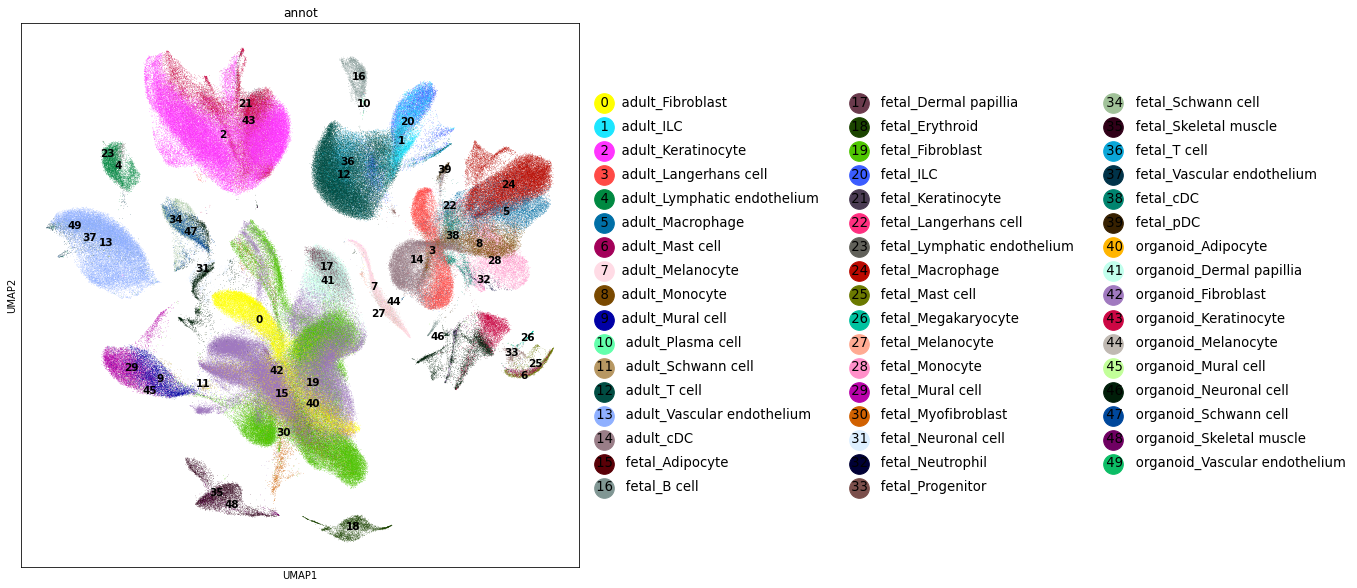

In [156]:
sk.plot_embedding(
    pooled_ad0,
    basis="umap",
    groupby="annot",
    figsize=(10, 10),
    legend_fontsize=12,
    size=1,
)

In [157]:
%%capture

with PdfPages("figures/figS1E.pdf") as pdf:
    sk.plot_embedding(
        pooled_ad0,
        basis="umap",
        groupby="annot",
        figsize=(15, 15),
        legend_fontsize=12,
        size=2,
    )
    pdf.savefig(bbox_inches="tight")
    sk.plot_embedding(
        pooled_ad0,
        basis="umap",
        groupby="annot",
        figsize=(15, 15),
        legend_fontsize=12,
        size=2,
        annot="none",
        frameon=False,
    )
    pdf.savefig(bbox_inches="tight")

In [155]:
!rclone copy --drive-shared-with-me figures/figS1E.pdf "google:/Fetal Skin/Figures/Figs_from_Ni/"

In [4]:
%%capture

sc.settings.set_figure_params(dpi_save=80)
with PdfPages("figures/figS1E_smaller.pdf") as pdf:
    sk.plot_embedding(
        pooled_ad0,
        basis="umap",
        groupby="annot",
        figsize=(10, 10),
        legend_fontsize=12,
        size=0.75,
    )
    pdf.savefig(bbox_inches="tight")
    sk.plot_embedding(
        pooled_ad0,
        basis="umap",
        groupby="annot",
        figsize=(10, 10),
        legend_fontsize=12,
        size=0.75,
        annot="none",
        frameon=False,
    )
    pdf.savefig(bbox_inches="tight", dpi=80)

In [5]:
!rclone copy --drive-shared-with-me figures/figS1E_smaller.pdf "google:/Fetal Skin/Figures/Figs_from_Ni/"

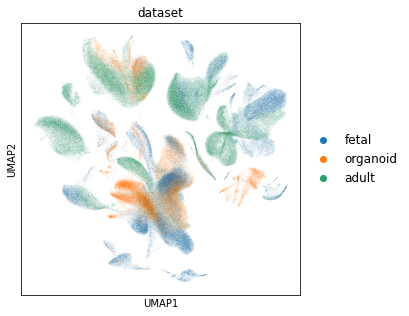

In [71]:
sc.pl.embedding(pooled_ad0, basis="umap", color="dataset", legend_fontsize=12, size=0.1);

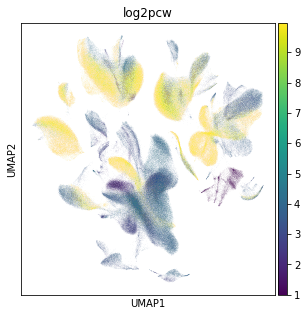

In [77]:
sc.pl.embedding(pooled_ad0, basis="umap", color="log2pcw", legend_fontsize=12, size=0.1);

# Distance calculation

## fetal vs adult vs organoid

In [5]:
pooled_ad0 = sc.read("h5ad/pooled_fetal_organoid_adult.processed.h5ad", backed="r")

In [6]:
pooled_ad0

AnnData object with n_obs × n_vars = 506107 × 46794 backed at 'h5ad/pooled_fetal_organoid_adult.processed.h5ad'
    obs: 'sanger_id', 'chemistry', 'batch', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation', 'is_maternal', 'fig1b_annotation', 'independent_annotation_refined_20220201a', 'independent_annotation_refined_20220201b', 'independent_annotation_broad1_20220201', 'independent_annotation_broad2_20220201', 'independent_annotation_broad3_20220201', 'joint_annotation_20220201a', 'joint_annotation_20220201b', 'fig1b_annotation_20220201', 'joint_annotation_20220202', 'independent_annotation_refined_2022

In [7]:
pb_annot_pca = sk.pseudo_bulk(pooled_ad0, groupby="annot", use_rep="X_pca_project", FUN=np.median).T

In [8]:
annot_dist_df = pd.DataFrame(
    scipy.spatial.distance_matrix(pb_annot_pca.values, pb_annot_pca.values),
    index=pb_annot_pca.index,
    columns=pb_annot_pca.index,
)

In [9]:
annot_dist_df.iloc[0:5, 0:5]

,adult_Fibroblast,adult_ILC,adult_Keratinocyte,adult_Langerhans cell,adult_Lymphatic endothelium
adult_Fibroblast,0.000000,24.446382,22.663383,23.395505,22.293357
adult_ILC,24.446382,0.000000,21.660081,19.662860,24.628276
adult_Keratinocyte,22.663383,21.660081,0.000000,19.766183,22.577697
adult_Langerhans cell,23.395505,19.662860,19.766183,0.000000,23.455877
adult_Lymphatic endothelium,22.293357,24.628276,22.577697,23.455877,0.000000


In [11]:
ct_shared_by_all = (
    annot_dist_df.index.to_series()
    .str.partition("_", expand=True)[2]
    .value_counts()
    .where(lambda x: x == 3)
    .dropna()
    .index
)

In [9]:
annot_dist_df_shared = annot_dist_df.loc[
    annot_dist_df.index.to_series().str.partition("_", expand=True)[2].isin(ct_shared_by_all),
    annot_dist_df.index.to_series().str.partition("_", expand=True)[2].isin(ct_shared_by_all),
]

In [10]:
annot_scaled_dist_df_shared = pd.DataFrame(
    minmax_scale(np.log1p(annot_dist_df_shared)),
    index=annot_dist_df_shared.index,
    columns=annot_dist_df_shared.index,
)

In [14]:
annot_scaled_dist_df_shared.columns

Index(['adult_Fibroblast', 'adult_Keratinocyte', 'adult_Melanocyte',
       'adult_Mural cell', 'adult_Schwann cell', 'adult_Vascular endothelium',
       'fetal_Fibroblast', 'fetal_Keratinocyte', 'fetal_Melanocyte',
       'fetal_Mural cell', 'fetal_Schwann cell', 'fetal_Vascular endothelium',
       'organoid_Fibroblast', 'organoid_Keratinocyte', 'organoid_Melanocyte',
       'organoid_Mural cell', 'organoid_Schwann cell',
       'organoid_Vascular endothelium'],
      dtype='object')

In [25]:
fig1d_ct_order = [
    "adult_Keratinocyte",
    "fetal_Keratinocyte",
    "organoid_Keratinocyte",
    "adult_Melanocyte",
    "fetal_Melanocyte",
    "organoid_Melanocyte",
    "adult_Mural cell",
    "fetal_Mural cell",
    "organoid_Mural cell",
    "adult_Fibroblast",
    "fetal_Fibroblast",
    "organoid_Fibroblast",
    "adult_Schwann cell",
    "fetal_Schwann cell",
    "organoid_Schwann cell",
    "adult_Vascular endothelium",
    "fetal_Vascular endothelium",
    "organoid_Vascular endothelium",
]

fig1d_df = annot_scaled_dist_df_shared[fig1d_ct_order].loc[fig1d_ct_order].T

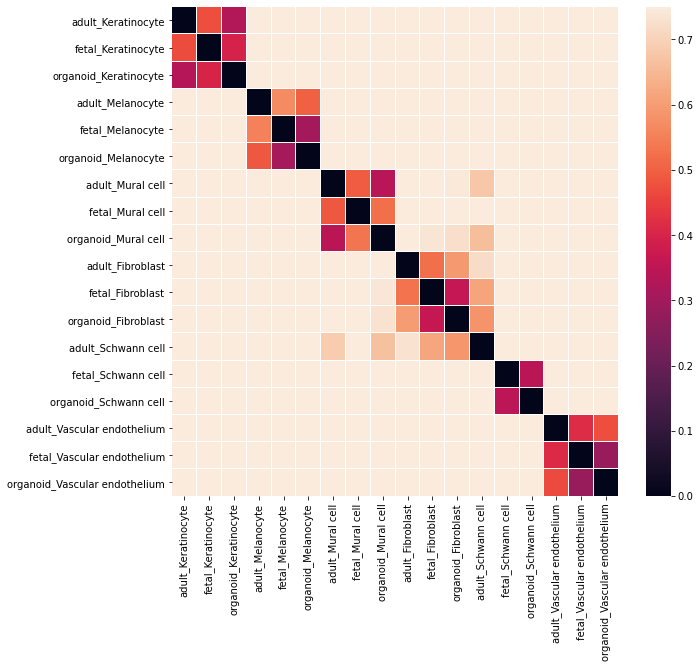

In [64]:
fig1D_g = sk.heatmap(fig1d_df, figsize=(10, 9), vmax=0.75, linewidth=0.01)
fig1D_g.figure.savefig("figures/fig1E.20220718.pdf", bbox_inches="tight")

In [65]:
!rclone copy --drive-shared-with-me figures/fig1E.20220718.pdf "google:/Fetal Skin/Figures/Figs_from_Ni/"

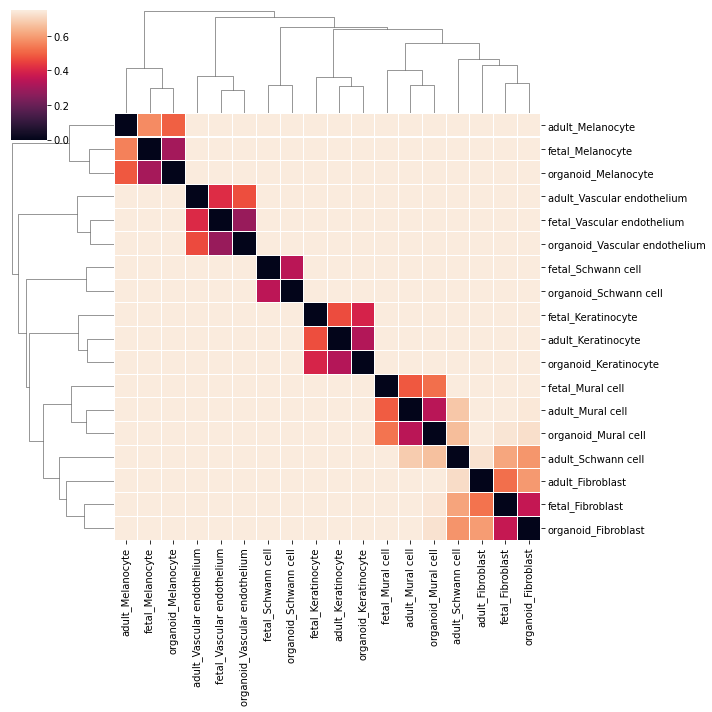

In [ ]:
fig1D_g = sn.clustermap(annot_scaled_dist_df_shared.T, figsize=(10, 10), vmax=0.75, linewidth=0.01)
fig1D_g.savefig("figures/fig1D_p1a.pdf")

In [17]:
annot_scaled_dist_df_shared = annot_scaled_dist_df_shared.loc[
    ~annot_scaled_dist_df_shared.index.str.startswith("fetal_"),
    annot_scaled_dist_df_shared.index.str.startswith("fetal_"),
]

fig1D part1

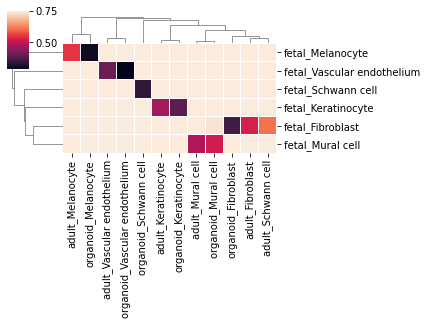

In [18]:
fig1D_g = sn.clustermap(annot_scaled_dist_df_shared.T, figsize=(6, 4.5), vmax=0.75, linewidth=0.01)
fig1D_g.savefig("figures/fig1D_p1b.pdf")

In [150]:
!rclone copy --drive-shared-with-me figures/fig1D_p1.pdf "google:/Fetal Skin/Figures/Figs_from_Ni/"

In [31]:
annot_scaled_dist_df = pd.DataFrame(
    minmax_scale(np.log1p(annot_dist_df)),
    index=annot_dist_df.index,
    columns=annot_dist_df.index,
)

In [58]:
figS1h_ct_order = [
    "adult_Keratinocyte",
    "fetal_Keratinocyte",
    "organoid_Keratinocyte",
    "adult_Melanocyte",
    "fetal_Melanocyte",
    "organoid_Melanocyte",
    "adult_Mural cell",
    "fetal_Mural cell",
    "organoid_Mural cell",
    "fetal_Dermal papillia",
    "organoid_Dermal papillia",
    "adult_Fibroblast",
    "fetal_Fibroblast",
    "fetal_Myofibroblast",
    "organoid_Fibroblast",
    "fetal_Adipocyte",
    "organoid_Adipocyte",
    "adult_Schwann cell",
    "fetal_Schwann cell",
    "organoid_Schwann cell",
    "adult_Vascular endothelium",
    "fetal_Vascular endothelium",
    "organoid_Vascular endothelium",
    "adult_Lymphatic endothelium",
    "fetal_Lymphatic endothelium",
    "fetal_Neuronal cell",
    "organoid_Neuronal cell",
    "fetal_Progenitor",
    "adult_Langerhans cell",
    "fetal_Langerhans cell",
    "adult_cDC",
    "fetal_cDC",
    "adult_Monocyte",
    "fetal_Monocyte",
    "adult_Macrophage",
    "fetal_Macrophage",
    "adult_Mast cell",
    "fetal_Mast cell",
    "fetal_Neutrophil",
    "adult_ILC",
    "fetal_ILC",
    "adult_T cell",
    "fetal_T cell",
    "fetal_pDC",
    "fetal_B cell",
    "adult_Plasma cell",
    "fetal_Skeletal muscle",
    "organoid_Skeletal muscle",
    "fetal_Erythroid",
    "fetal_Megakaryocyte",
]

figS1h_df = annot_scaled_dist_df[figS1h_ct_order].loc[figS1h_ct_order]

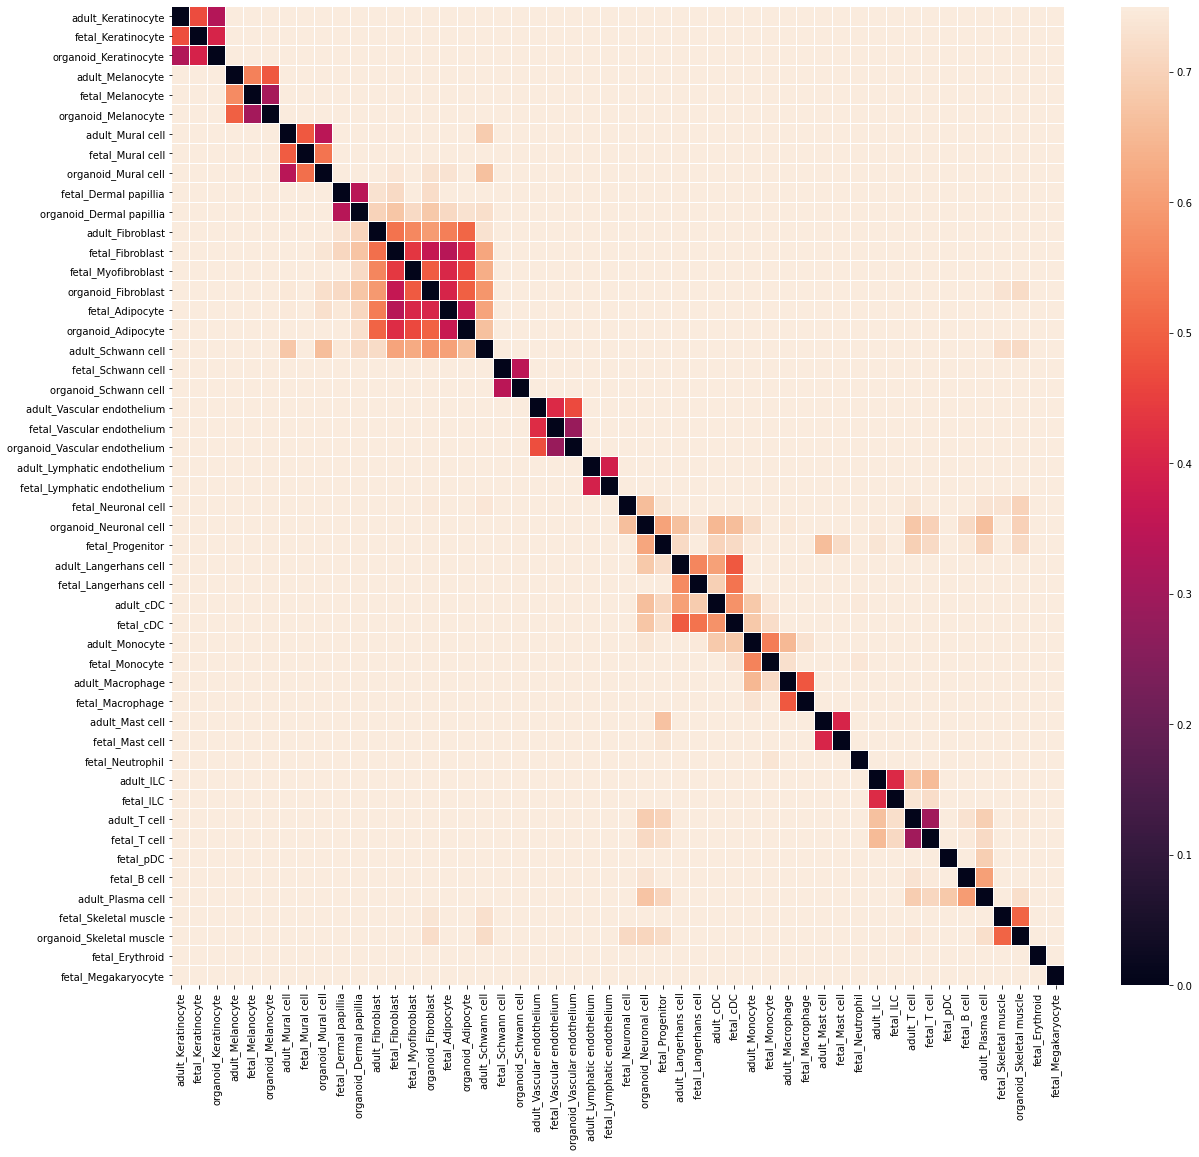

In [62]:
figS1h_g = sk.heatmap(figS1h_df, figsize=(20, 18), vmax=0.75, linewidth=0.01)
figS1h_g.figure.savefig("figures/figS1h.20220718.pdf", bbox_inches="tight")

In [63]:
!rclone copy --drive-shared-with-me figures/figS1h.20220718.pdf "google:/Fetal Skin/Figures/Figs_from_Ni/"

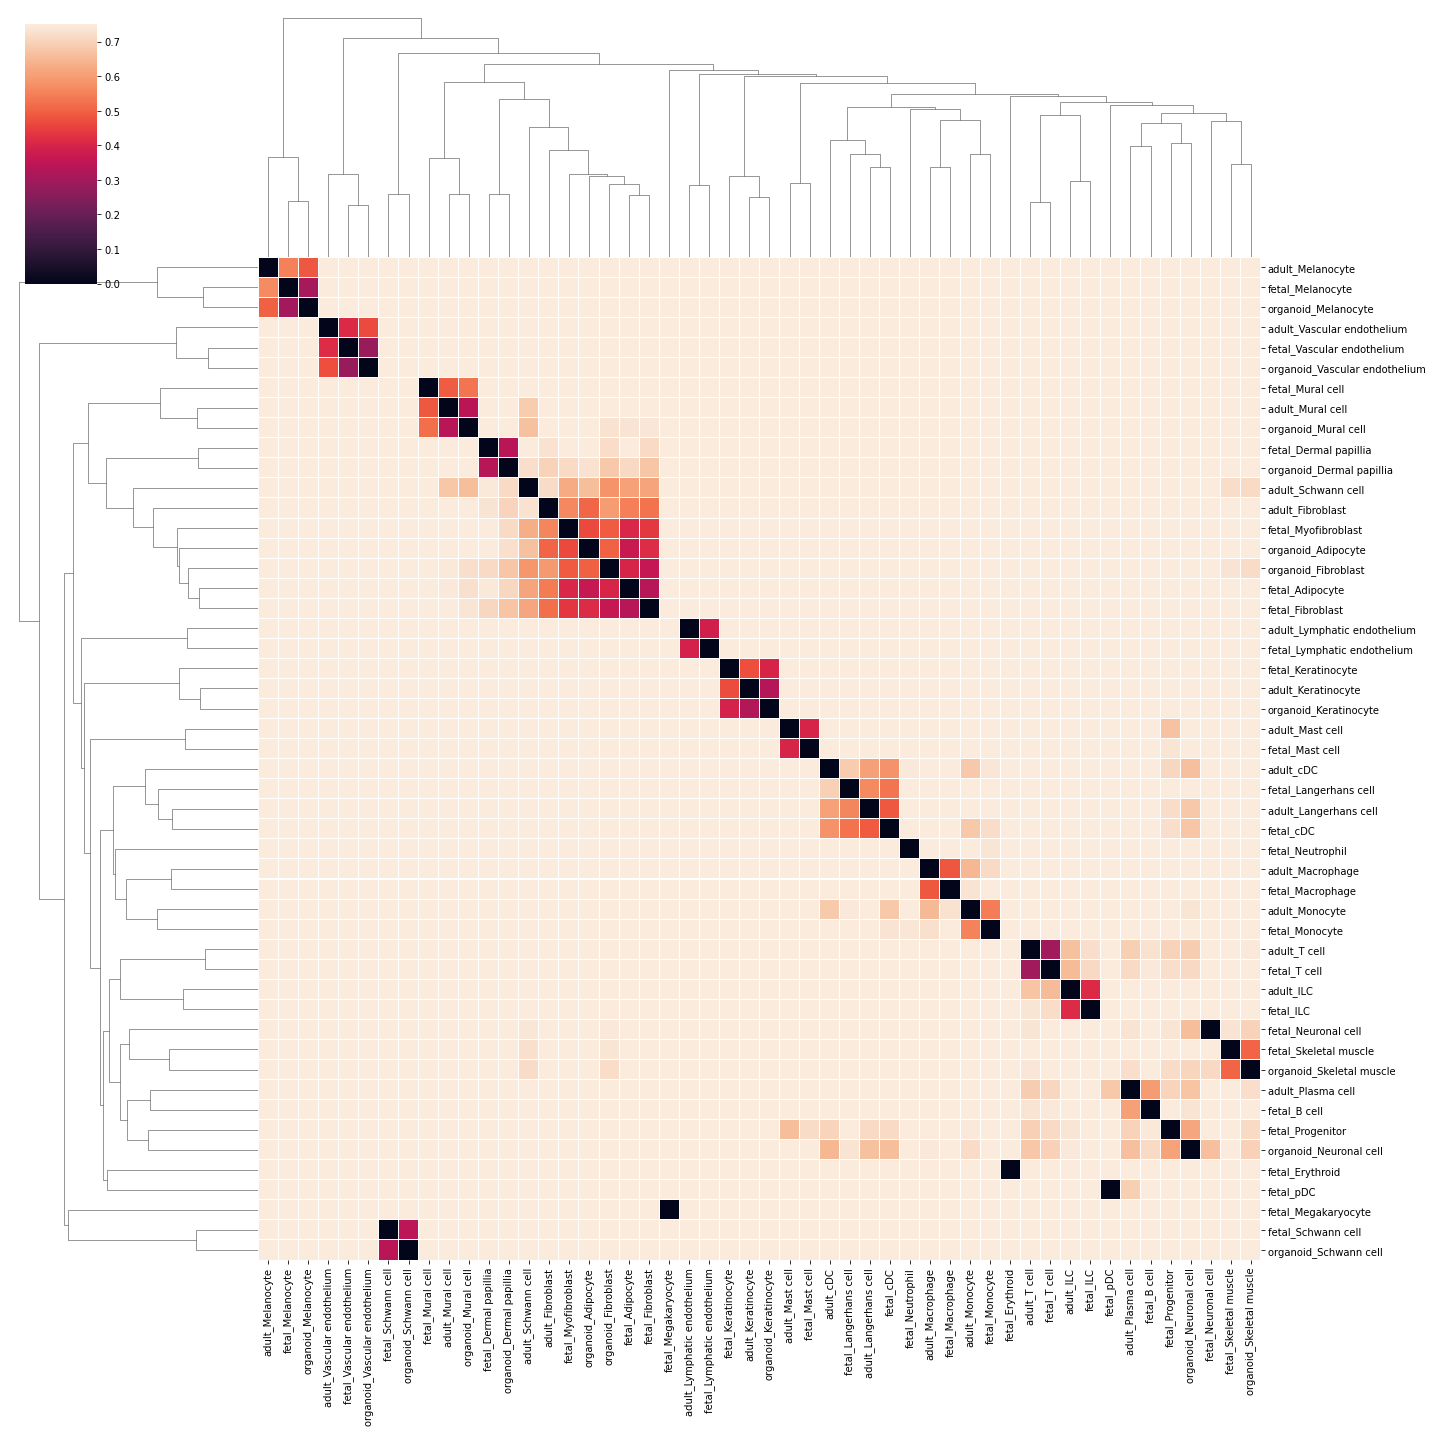

In [148]:
figS1F_g = sn.clustermap(annot_scaled_dist_df, figsize=(20, 20), vmax=0.75, linewidth=0.01)
figS1F_g.savefig("figures/figS1F_p1.pdf")

In [151]:
!rclone copy --drive-shared-with-me figures/figS1F_p1.pdf "google:/Fetal Skin/Figures/Figs_from_Ni/"

## early/late fetal vs adult vs organoid

### define early/late by milo analysis

In [114]:
early_fsk_cells = pd.read_csv(
    "fetal_skin.scvi_donor.milo.fig1b_annotation_vs_pcw.early_cells.list", names=["cell"]
).cell
late_fsk_cells = pd.read_csv(
    "fetal_skin.scvi_donor.milo.fig1b_annotation_vs_pcw.late_cells.list", names=["cell"]
).cell

In [115]:
tmp_cells = early_fsk_cells[early_fsk_cells.isin(late_fsk_cells)]

In [116]:
tmp_cells.size

936

In [117]:
early_fsk_cells = early_fsk_cells[~early_fsk_cells.isin(tmp_cells)]
late_fsk_cells = late_fsk_cells[~late_fsk_cells.isin(tmp_cells)]

### broad annotation

In [118]:
pooled_ad0.obs["annot_early_late"] = pooled_ad0.obs.annot.astype(str)
k_early_fsk = pooled_ad0.obs_names.isin(early_fsk_cells + "-fetal")
k_late_fsk = pooled_ad0.obs_names.isin(late_fsk_cells + "-fetal")
pooled_ad0.obs.loc[k_early_fsk, "annot_early_late"] = (
    "early-" + pooled_ad0.obs.loc[k_early_fsk, "annot_early_late"]
)
pooled_ad0.obs.loc[k_late_fsk, "annot_early_late"] = (
    "late-" + pooled_ad0.obs.loc[k_late_fsk, "annot_early_late"]
)
pooled_ad0.obs["annot_early_late"] = pooled_ad0.obs["annot_early_late"].astype("category")

In [119]:
pb_annot_pca2 = sk.pseudo_bulk(
    pooled_ad0, groupby="annot_early_late", use_rep="X_pca_project", FUN=np.median
).T

In [120]:
annot_dist_df2 = pd.DataFrame(
    scipy.spatial.distance_matrix(pb_annot_pca2.values, pb_annot_pca2.values),
    index=pb_annot_pca2.index,
    columns=pb_annot_pca2.index,
)

In [121]:
annot_dist_df2.iloc[0:5, 0:5]

,adult_Fibroblast,adult_ILC,adult_Keratinocyte,adult_Langerhans cell,adult_Lymphatic endothelium
adult_Fibroblast,0.000000,24.446382,22.663383,23.395505,22.293357
adult_ILC,24.446382,0.000000,21.660081,19.662860,24.628276
adult_Keratinocyte,22.663383,21.660081,0.000000,19.766183,22.577697
adult_Langerhans cell,23.395505,19.662860,19.766183,0.000000,23.455877
adult_Lymphatic endothelium,22.293357,24.628276,22.577697,23.455877,0.000000


In [ ]:
ct_shared_by_all = (
    annot_dist_df.index.to_series()
    .str.partition("_", expand=True)[2]
    .value_counts()
    .where(lambda x: x == 3)
    .dropna()
    .index
)

In [123]:
ct_shared_by_all

Index(['Keratinocyte', 'Mural cell', 'Fibroblast', 'Schwann cell',
       'Melanocyte', 'Vascular endothelium'],
      dtype='object')

In [124]:
annot_dist_df_shared2 = annot_dist_df2.loc[
    annot_dist_df2.index.to_series().str.partition("_", expand=True)[2].isin(ct_shared_by_all),
    annot_dist_df2.index.to_series().str.partition("_", expand=True)[2].isin(ct_shared_by_all),
]

annot_dist_df_shared2 = annot_dist_df_shared2.loc[
    ~annot_dist_df_shared2.index.str.startswith("fetal_"),
    ~annot_dist_df_shared2.index.str.startswith("fetal_"),
]

In [125]:
annot_scaled_dist_df_shared2 = pd.DataFrame(
    minmax_scale(np.log1p(annot_dist_df_shared2)),
    index=annot_dist_df_shared2.index,
    columns=annot_dist_df_shared2.index,
)

In [126]:
annot_scaled_dist_df_shared2 = annot_scaled_dist_df_shared2.loc[
    ~(
        annot_scaled_dist_df_shared2.index.str.startswith("early-fetal_")
        | annot_scaled_dist_df_shared2.index.str.startswith("late-fetal_")
    ),
    annot_scaled_dist_df_shared2.index.str.startswith("early-fetal_")
    | annot_scaled_dist_df_shared2.index.str.startswith("late-fetal_"),
]

fig1D part2

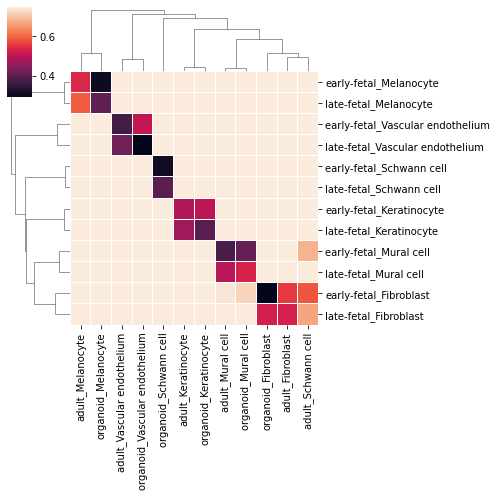

In [141]:
fig1Dp2_g = sn.clustermap(annot_scaled_dist_df_shared2.T, figsize=(7, 7), vmax=0.75, linewidth=0.01)
fig1Dp2_g.savefig("figures/fig1D_p2a.pdf")

In [142]:
!rclone copy --drive-shared-with-me figures/fig1D_p2a.pdf "google:/Fetal Skin/Figures/Figs_from_Ni/"

### refined adult annotation

In [129]:
pooled_ad0.obs["annot_early_late2"] = pooled_ad0.obs.annot.astype(str)
pooled_ad0.obs.loc[
    pooled_ad0.obs.dataset == "adult", "annot_early_late2"
] = "adult_" + pooled_ad0.obs.loc[pooled_ad0.obs.dataset == "adult", "anno_final"].astype(str)
k_early_fsk = pooled_ad0.obs_names.isin(early_fsk_cells + "-fetal")
k_late_fsk = pooled_ad0.obs_names.isin(late_fsk_cells + "-fetal")
pooled_ad0.obs.loc[k_early_fsk, "annot_early_late2"] = (
    pooled_ad0.obs.loc[k_early_fsk, "annot_early_late2"] + ", early"
)
pooled_ad0.obs.loc[k_late_fsk, "annot_early_late2"] = (
    pooled_ad0.obs.loc[k_late_fsk, "annot_early_late2"] + ", late"
)
pooled_ad0.obs["annot_early_late2"] = pooled_ad0.obs["annot_early_late2"].astype("category")

In [130]:
pb_annot_pca3 = sk.pseudo_bulk(
    pooled_ad0[pooled_ad0.obs.dataset != "organoid"],
    groupby="annot_early_late2",
    use_rep="X_pca_project",
    FUN=np.median,
).T

In [131]:
annot_dist_df3 = pd.DataFrame(
    scipy.spatial.distance_matrix(pb_annot_pca3.values, pb_annot_pca3.values),
    index=pb_annot_pca3.index,
    columns=pb_annot_pca3.index,
)

In [132]:
annot_dist_df3.iloc[0:5, 0:5]

,adult_C_Melanocyte,adult_DC1,adult_DC2,adult_F1,adult_F2
adult_C_Melanocyte,0.000000,31.699925,32.920710,35.620639,32.585339
adult_DC1,31.699925,0.000000,8.297773,23.479541,19.998832
adult_DC2,32.920710,8.297773,0.000000,24.530138,20.466602
adult_F1,35.620639,23.479541,24.530138,0.000000,10.448977
adult_F2,32.585339,19.998832,20.466602,10.448977,0.000000


In [133]:
annot_scaled_dist_df3 = pd.DataFrame(
    minmax_scale(np.log1p(annot_dist_df3)),
    index=annot_dist_df3.index,
    columns=annot_dist_df3.index,
)

In [134]:
annot_scaled_dist_df3e = annot_scaled_dist_df3.loc[
    annot_scaled_dist_df3.index.str.endswith(", early"),
    annot_scaled_dist_df3.index.str.startswith("adult_"),
]
annot_scaled_dist_df3l = annot_scaled_dist_df3.loc[
    annot_scaled_dist_df3.index.str.endswith(", late"),
    annot_scaled_dist_df3.index.str.startswith("adult_"),
]

In [135]:
annot_scaled_dist_df3e.index = annot_scaled_dist_df3e.index.str.replace(", early", "")
annot_scaled_dist_df3l.index = annot_scaled_dist_df3l.index.str.replace(", late", "")

In [136]:
annot_scaled_dist_df3 = annot_scaled_dist_df3.loc[
    annot_scaled_dist_df3.index.str.endswith(", early")
    | annot_scaled_dist_df3.index.str.endswith(", late"),
    annot_scaled_dist_df3.index.str.startswith("adult_"),
]

fig1D part2

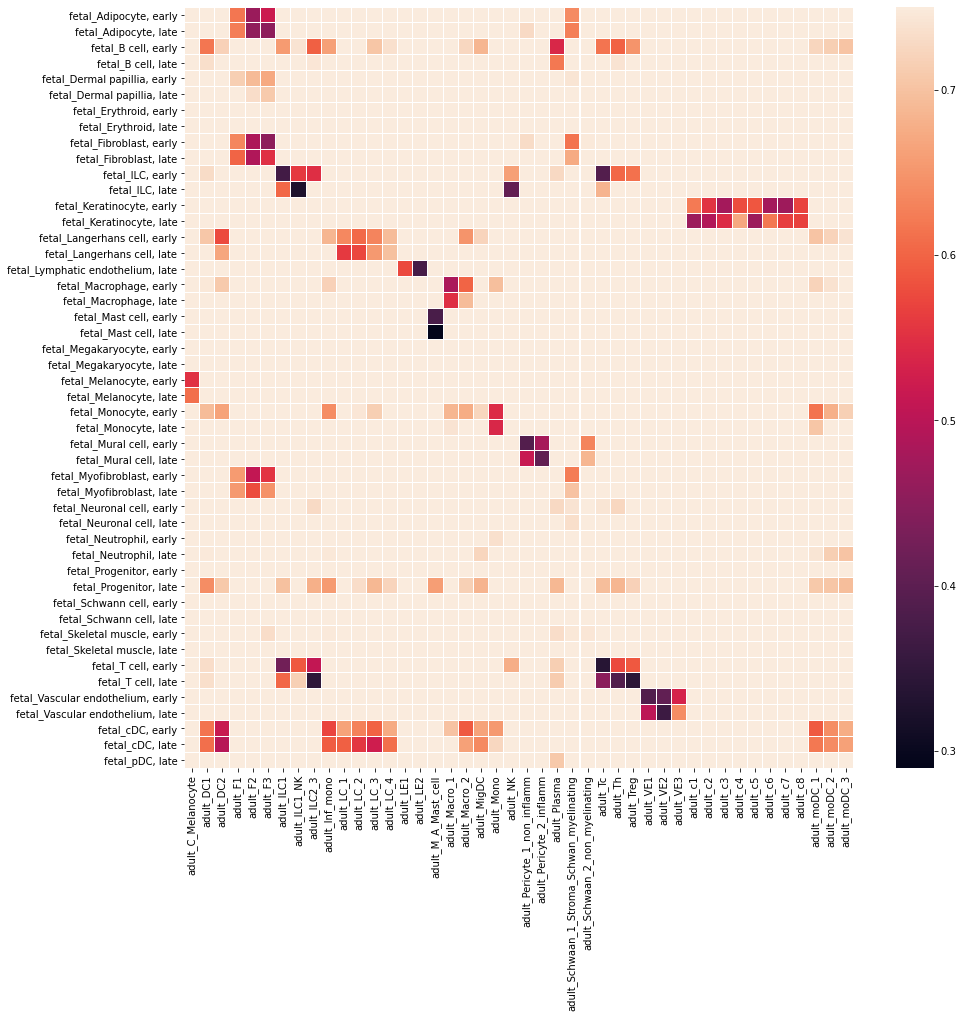

In [143]:
sk.set_figsize((15, 14))
fig1Dp2_g = sn.heatmap(annot_scaled_dist_df3, vmax=0.75, linewidth=0.01)
plt.savefig("figures/fig1D_p2b.pdf", bbox_inches="tight")

In [145]:
!rclone copy --drive-shared-with-me figures/fig1D_p2b.pdf "google:/Fetal Skin/Figures/Figs_from_Ni/"

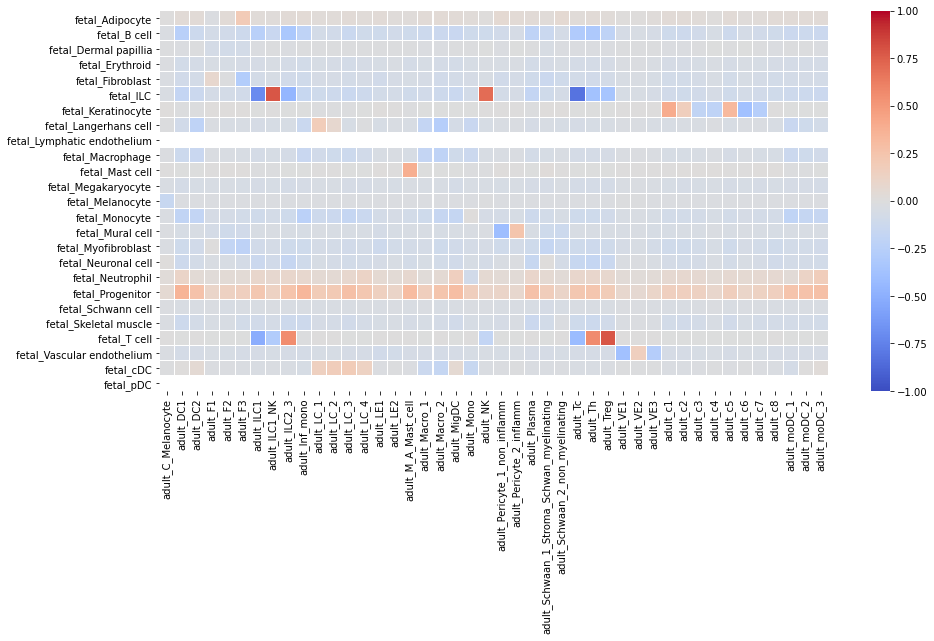

In [159]:
sk.set_figsize((15, 7))
fig1Dp2_g = sn.heatmap(
    np.log2(annot_scaled_dist_df3e / annot_scaled_dist_df3l),
    vmin=-1,
    vmax=1,
    linewidth=0.01,
    cmap="coolwarm",
)
plt.savefig("figures/fig1D_p2c.pdf", bbox_inches="tight")

## between stages

In [89]:
pooled_ad0.obs.pcw.apply(lambda x: f"{x:03d}")

AAACCTGGTCAGTGGA-1-4834STDY7002879-fetal    008
AAAGATGGTCGATTGT-1-4834STDY7002879-fetal    008
AAAGCAAAGATGTGGC-1-4834STDY7002879-fetal    008
AAAGTAGCAGATCGGA-1-4834STDY7002879-fetal    008
AAAGTAGTCCGCATCT-1-4834STDY7002879-fetal    008
                                           ... 
TTTGGTTTCAGGCCCA-1-4820STDY7389014-adult    999
TTTGGTTTCGCCTGTT-1-4820STDY7389014-adult    999
TTTGTCAAGGAATCGC-1-4820STDY7389014-adult    999
TTTGTCAAGGACTGGT-1-4820STDY7389014-adult    999
TTTGTCACACTACAGT-1-4820STDY7389014-adult    999
Name: pcw, Length: 506107, dtype: object

In [14]:
pooled_ad0.obs["annot_timepoint"] = (
    pooled_ad0.obs.annot.astype(str) + ", " + pooled_ad0.obs.pcw.apply(lambda x: f"{x:03d}")
)
pooled_ad0.obs["annot_timepoint"] = pooled_ad0.obs["annot_timepoint"].astype("category")

In [12]:
ct_shared_by_fsk_org = (
    pooled_ad0.obs.loc[pooled_ad0.obs.dataset != "adult", "annot"]
    .unique()
    .categories.to_series()
    .str.partition("_")[2]
    .value_counts()
    .where(lambda x: x == 2)
    .dropna()
    .index.to_list()
)

In [92]:
pooled_ad0.obs.annot_timepoint.cat.categories

Index(['adult_Fibroblast, 999', 'adult_ILC, 999', 'adult_Keratinocyte, 999',
       'adult_Langerhans cell, 999', 'adult_Lymphatic endothelium, 999',
       'adult_Macrophage, 999', 'adult_Mast cell, 999',
       'adult_Melanocyte, 999', 'adult_Monocyte, 999', 'adult_Mural cell, 999',
       ...
       'organoid_Skeletal muscle, 002', 'organoid_Skeletal muscle, 004',
       'organoid_Skeletal muscle, 007', 'organoid_Skeletal muscle, 012',
       'organoid_Skeletal muscle, 019', 'organoid_Vascular endothelium, 002',
       'organoid_Vascular endothelium, 004',
       'organoid_Vascular endothelium, 007',
       'organoid_Vascular endothelium, 012',
       'organoid_Vascular endothelium, 019'],
      dtype='object', length=293)

In [108]:
pb_annot_timepoint_pca = sk.pseudo_bulk(
    pooled_ad0, groupby="annot_timepoint", use_rep="X_pca_project", FUN=np.mean
).T

In [109]:
dist_df = pd.DataFrame(
    scipy.spatial.distance_matrix(pb_annot_timepoint_pca.values, pb_annot_timepoint_pca.values),
    index=pb_annot_timepoint_pca.index,
    columns=pb_annot_timepoint_pca.index,
)

In [95]:
dist_df.shape

(293, 293)

In [96]:
dist_df.iloc[0:5, 0:5]

,"adult_Fibroblast, 999","adult_ILC, 999","adult_Keratinocyte, 999","adult_Langerhans cell, 999","adult_Lymphatic endothelium, 999"
"adult_Fibroblast, 999",0.000000,24.446382,22.663383,23.395505,22.293357
"adult_ILC, 999",24.446382,0.000000,21.660081,19.662860,24.628276
"adult_Keratinocyte, 999",22.663383,21.660081,0.000000,19.766183,22.577697
"adult_Langerhans cell, 999",23.395505,19.662860,19.766183,0.000000,23.455877
"adult_Lymphatic endothelium, 999",22.293357,24.628276,22.577697,23.455877,0.000000


In [110]:
dist_df.index.to_series().str.partition("_")[2].str.partition(", ")[0]

adult_Fibroblast, 999                            Fibroblast
adult_ILC, 999                                          ILC
adult_Keratinocyte, 999                        Keratinocyte
adult_Langerhans cell, 999                  Langerhans cell
adult_Lymphatic endothelium, 999      Lymphatic endothelium
                                              ...          
organoid_Vascular endothelium, 002     Vascular endothelium
organoid_Vascular endothelium, 004     Vascular endothelium
organoid_Vascular endothelium, 007     Vascular endothelium
organoid_Vascular endothelium, 012     Vascular endothelium
organoid_Vascular endothelium, 019     Vascular endothelium
Name: 0, Length: 293, dtype: object

In [111]:
dist_dfs = {}
for ct in ct_shared_by_fsk_org:
    tmp_df = dist_df.loc[
        dist_df.index.str.startswith("organoid_")
        & (dist_df.index.to_series().str.partition("_")[2].str.partition(", ")[0] == ct),
        dist_df.columns[
            dist_df.columns.str.startswith("fetal_")
            & (dist_df.columns.to_series().str.partition("_")[2].str.partition(", ")[0] == ct)
        ],
    ]
    dist_dfs[ct] = pd.DataFrame(
        minmax_scale(tmp_df, axis=0), index=tmp_df.index, columns=tmp_df.columns
    )

In [164]:
pooled_ad0.obs.loc[
    pooled_ad0.obs.annot_timepoint.str.startswith("organoid_Vascular"), "annot_timepoint"
].value_counts().where(lambda x: x > 0).dropna().sort_index().astype(int)

organoid_Vascular endothelium, 002     1
organoid_Vascular endothelium, 004     7
organoid_Vascular endothelium, 007    45
organoid_Vascular endothelium, 012    66
organoid_Vascular endothelium, 019    12
Name: annot_timepoint, dtype: int64

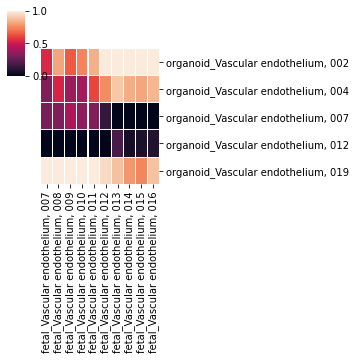

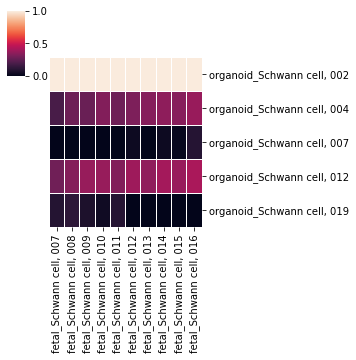

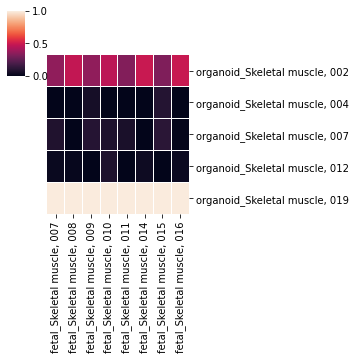

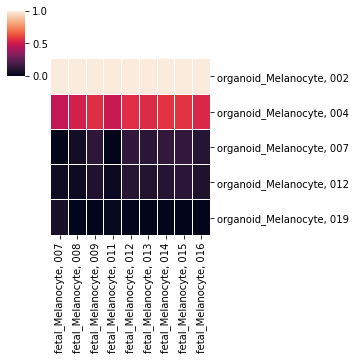

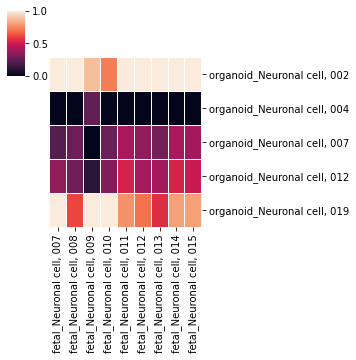

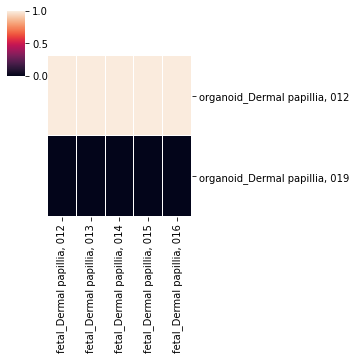

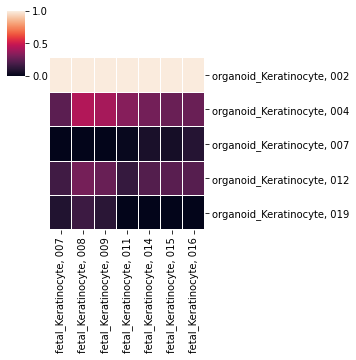

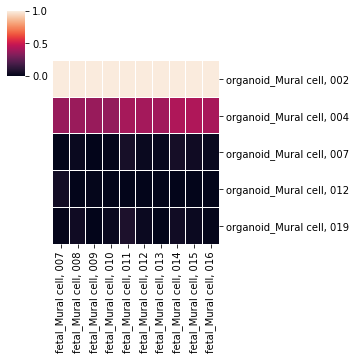

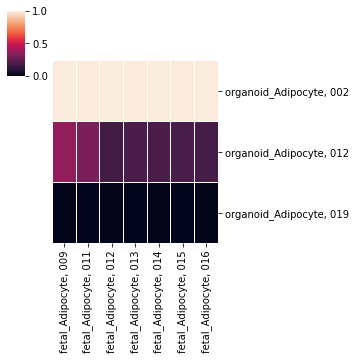

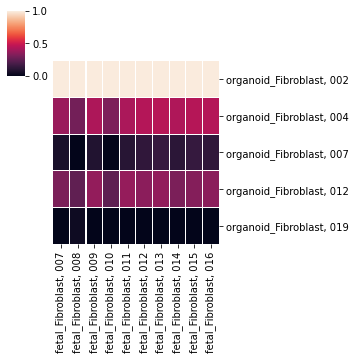

In [112]:
for ct in ct_shared_by_fsk_org:
    sn.clustermap(
        dist_dfs[ct], figsize=(5, 5), linewidth=0.01, col_cluster=False, row_cluster=False
    );

# LR based on genes

In [10]:
ask_lr = sk.LR_train(
    pooled_ad0[pooled_ad0.obs.dataset == "adult"],
    groupby="annot",
    use_rep="X",
    downsample_to=(200, "adult_skin.norm.downsampled_for_LR.h5ad"),
    save="adult_broad.pooled_fsk_ask_org.lognorm.LR.pkl",
)

In [11]:
fsk_lr = sk.LR_train(
    pooled_ad0[pooled_ad0.obs.dataset == "fetal"],
    groupby="annot",
    use_rep="X",
    downsample_to=(200, "fetal_skin.norm.downsampled_for_LR.h5ad"),
    save="fetal_broad.pooled_fsk_ask_org.lognorm.LR.pkl",
)

In [12]:
org_lr = sk.LR_train(
    pooled_ad0[pooled_ad0.obs.dataset == "organoid"],
    groupby="annot",
    use_rep="X",
    downsample_to=(200, "organoid_skin.norm.downsampled_for_LR.h5ad"),
    save="organoid_broad.pooled_fsk_ask_org.lognorm.LR.pkl",
)

In [13]:
fsk_pred = sk.LR_predict(
    pooled_ad0, fsk_lr, use_rep="X", key_added="fsk_lognorm_annot", return_predict=True
)
ask_pred = sk.LR_predict(
    pooled_ad0, ask_lr, use_rep="X", key_added="ask_lognorm_annot", return_predict=True
)
org_pred = sk.LR_predict(
    pooled_ad0, org_lr, use_rep="X", key_added="org_lognorm_annot", return_predict=True
)

46794 features used for prediction
46794 features used for prediction
46794 features used for prediction


In [147]:
fsk_pred_df = pd.DataFrame(
    npg.aggregate_np(pooled_ad0.obs.annot.cat.codes, fsk_pred["prob"].values, func=np.mean, axis=0),
    index=pooled_ad0.obs.annot.cat.categories,
    columns=fsk_pred["prob"].columns,
)

In [148]:
ask_pred_df = pd.DataFrame(
    npg.aggregate_np(pooled_ad0.obs.annot.cat.codes, ask_pred["prob"].values, func=np.mean, axis=0),
    index=pooled_ad0.obs.annot.cat.categories,
    columns=ask_pred["prob"].columns,
)

In [149]:
org_pred_df = pd.DataFrame(
    npg.aggregate_np(pooled_ad0.obs.annot.cat.codes, org_pred["prob"].values, func=np.mean, axis=0),
    index=pooled_ad0.obs.annot.cat.categories,
    columns=org_pred["prob"].columns,
)

In [150]:
pred_prob_df = pd.concat([fsk_pred_df, ask_pred_df, org_pred_df], axis=1)

In [151]:
ct_shared_by_all = (
    pred_prob_df.index.to_series()
    .str.partition("_", expand=True)[2]
    .value_counts()
    .where(lambda x: x == 3)
    .dropna()
    .index
)

In [20]:
ct_shared_by_all

Index(['Keratinocyte', 'Mural cell', 'Fibroblast', 'Schwann cell',
       'Melanocyte', 'Vascular endothelium'],
      dtype='object')

In [152]:
pred_prob_df.loc[
    (
        ~pred_prob_df.columns.str.startswith("fetal_")
        & pred_prob_df.columns.to_series().str.partition("_")[2].isin(ct_shared_by_all)
    ),
    (
        pred_prob_df.index.str.startswith("fetal_")
        & pred_prob_df.index.to_series().str.partition("_")[2].isin(ct_shared_by_all)
    ),
].T

,adult_Fibroblast,adult_Keratinocyte,adult_Melanocyte,adult_Mural cell,adult_Schwann cell,adult_Vascular endothelium,organoid_Fibroblast,organoid_Keratinocyte,organoid_Melanocyte,organoid_Mural cell,organoid_Schwann cell,organoid_Vascular endothelium
fetal_Fibroblast,0.209526,0.000394,0.002297,0.006385,0.055514,0.000884,0.836390,0.007651,0.026804,0.313990,0.014992,0.012875
fetal_Keratinocyte,0.046687,0.945235,0.021959,0.031573,0.045774,0.009144,0.009667,0.962672,0.011705,0.010309,0.005357,0.003448
fetal_Melanocyte,0.042659,0.002160,0.843316,0.032570,0.029628,0.006043,0.003261,0.003056,0.859961,0.011513,0.012996,0.007280
fetal_Mural cell,0.069609,0.001145,0.007505,0.574397,0.327638,0.010441,0.005489,0.000678,0.001575,0.500044,0.003178,0.004933
fetal_Schwann cell,0.020606,0.000611,0.013725,0.011535,0.035714,0.002243,0.005989,0.000990,0.004020,0.010334,0.844762,0.006984
fetal_Vascular endothelium,0.038441,0.002625,0.006485,0.039979,0.077339,0.889130,0.001614,0.000899,0.001321,0.009219,0.001921,0.886449


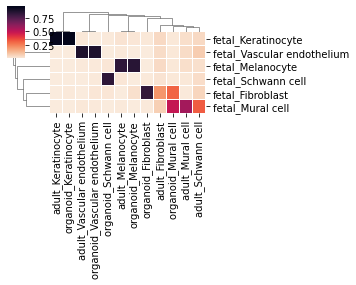

In [157]:
sn.clustermap(
    pred_prob_df.loc[
        (
            ~pred_prob_df.columns.str.startswith("fetal_")
            & pred_prob_df.columns.to_series().str.partition("_")[2].isin(ct_shared_by_all)
        ),
        (
            pred_prob_df.index.str.startswith("fetal_")
            & pred_prob_df.index.to_series().str.partition("_")[2].isin(ct_shared_by_all)
        ),
    ].T,
    cmap="rocket_r",
    linewidth=0.01,
    # vmin=0,
    # vmax=1,
    figsize=(5, 4),
);

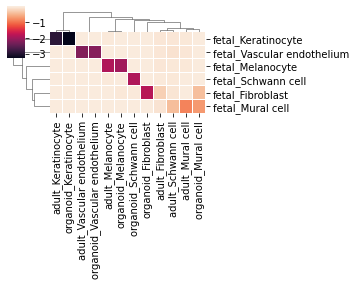

In [156]:
sn.clustermap(
    np.log(
        1
        - pred_prob_df.loc[
            (
                ~pred_prob_df.columns.str.startswith("fetal_")
                & pred_prob_df.columns.to_series().str.partition("_")[2].isin(ct_shared_by_all)
            ),
            (
                pred_prob_df.index.str.startswith("fetal_")
                & pred_prob_df.index.to_series().str.partition("_")[2].isin(ct_shared_by_all)
            ),
        ].T
    ),
    cmap="rocket",
    linewidth=0.01,
    figsize=(5, 4),
);

## between stages

In [167]:
!mkdir -p LR_models

In [15]:
fsk_models = {}
fsk2org_predictions = {}
for ct in ct_shared_by_fsk_org:
    fsk_ad = pooled_ad0[
        (pooled_ad0.obs.dataset == "fetal") & (pooled_ad0.obs.annot.str.endswith(ct))
    ]
    org_ad = pooled_ad0[
        (pooled_ad0.obs.dataset == "organoid") & (pooled_ad0.obs.annot.str.endswith(ct))
    ]
    model_pkl = f"LR_models/fetal_{ct.replace(' ', '-')}_by_timepoint.lognorm.pkl"
    if os.path.exists(model_pkl):
        lr = joblib.load(model_pkl)
    else:
        lr = sk.LR_train(
            fsk_ad,
            groupby="annot_timepoint",
            use_rep="X",
            downsample_to=(200, "tmp.h5ad"),
            save=model_pkl,
        )
    fsk_models[ct] = lr
    pred = sk.LR_predict(org_ad, lr, use_rep="X", return_predict=True)
    prob_df = pd.DataFrame(
        npg.aggregate_np(
            org_ad.obs.annot_timepoint.cat.codes,
            pred["prob"].values,
            func=np.median,
            axis=0,
        ),
        index=org_ad.obs.annot_timepoint.cat.categories,
        columns=pred["prob"].columns,
    )
    prop_df = pd.crosstab(org_ad.obs.annot_timepoint, pred["label"])
    fsk2org_predictions[ct] = {"prob": prob_df, "prop": prop_df}

46794 features used for prediction
46794 features used for prediction
46794 features used for prediction
46794 features used for prediction
46794 features used for prediction
46794 features used for prediction
46794 features used for prediction
46794 features used for prediction
46794 features used for prediction
46794 features used for prediction


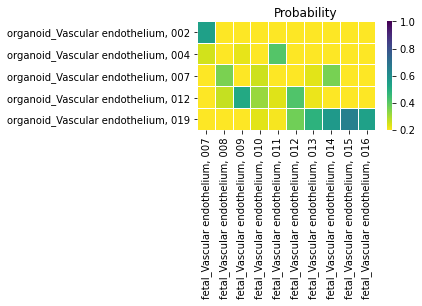

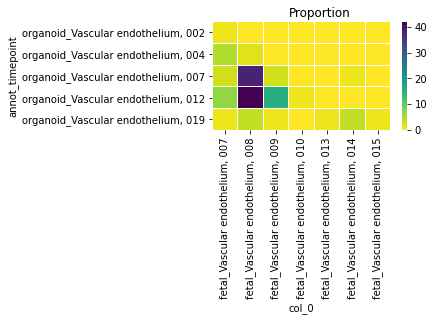

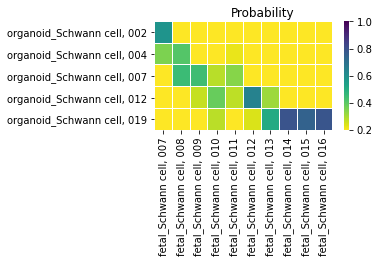

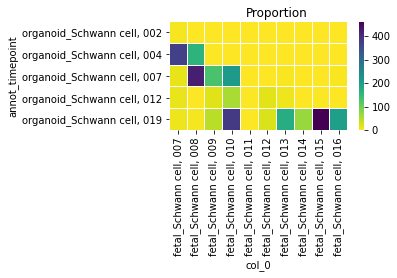

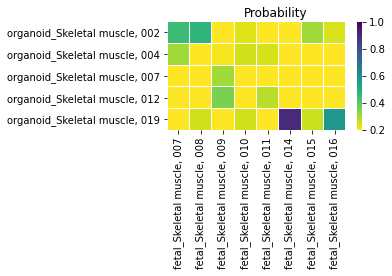

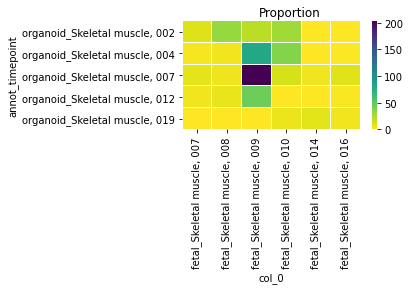

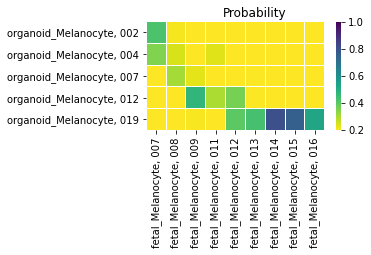

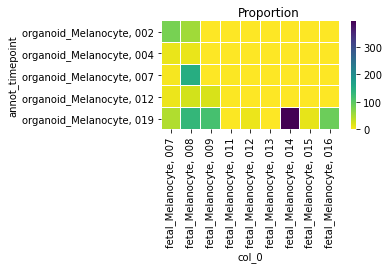

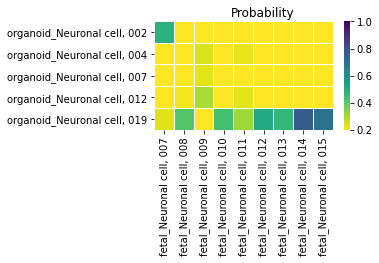

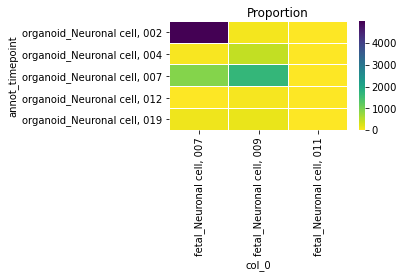

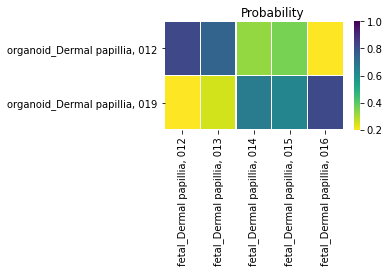

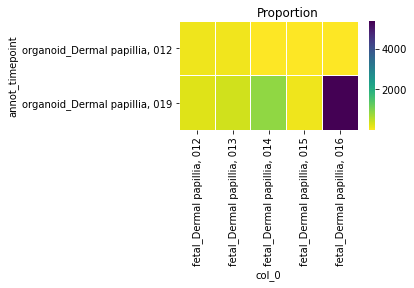

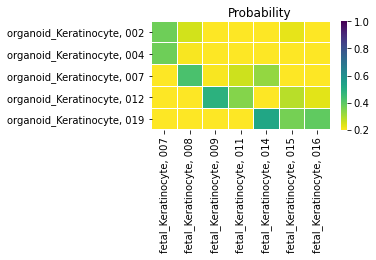

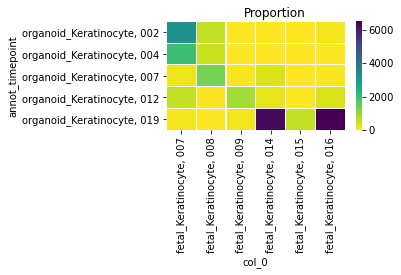

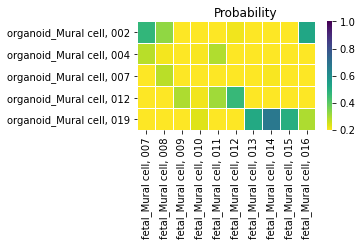

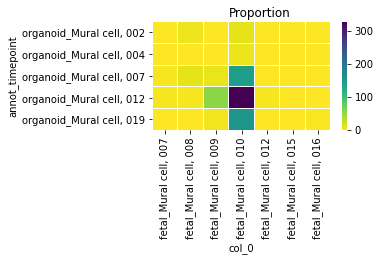

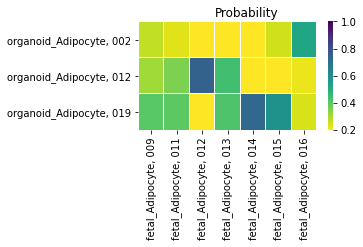

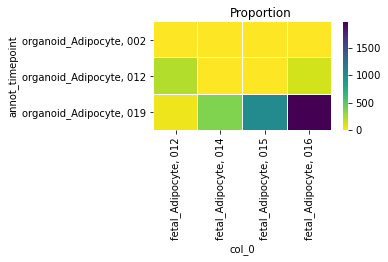

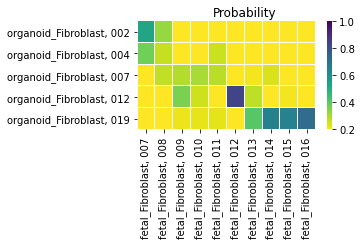

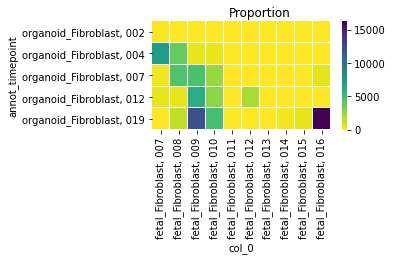

In [339]:
sk.set_figsize((4, 2))
for ct in ct_shared_by_fsk_org:
    sn.heatmap(
        fsk2org_predictions[ct]["prob"]
        / np.linalg.norm(fsk2org_predictions[ct]["prob"], ord=1, axis=0),
        cmap="viridis_r",
        linewidth=0.01,
        vmin=0.2,
        vmax=1,
    )
    plt.suptitle(f"Probability")
    plt.show()
    sn.heatmap(
        fsk2org_predictions[ct]["prop"],
        cmap="viridis_r",
        linewidth=0.01,
    )
    plt.suptitle(f"Proportion")
    plt.show()

In [335]:
ct_shared_by_fsk_org

['Vascular endothelium',
 'Schwann cell',
 'Skeletal muscle',
 'Melanocyte',
 'Neuronal cell',
 'Dermal papillia',
 'Keratinocyte',
 'Mural cell',
 'Adipocyte',
 'Fibroblast']

### probability

In [340]:
mean_prob_df = (
    pd.concat(
        [
            pd.melt(fsk2org_predictions[ct]["prob"].reset_index(), id_vars=["index"])
            .assign(celltype=ct)
            .replace(regex={f"(fetal|organoid)_{ct}, 0": ""})
            for ct in ct_shared_by_fsk_org  # if ct not in ["Adipocyte"]
        ]
    )
    .rename(columns={"index": "organoid_stage", "variable": "fetal_stage", "value": "probability"})
    .groupby(["organoid_stage", "fetal_stage"])
    .mean()
    .reset_index()
    .pivot(index=["organoid_stage"], columns=["fetal_stage"])
    .droplevel(0, axis=1)
)

<AxesSubplot:xlabel='fetal_stage', ylabel='organoid_stage'>

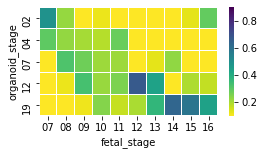

In [341]:
sn.heatmap(
    mean_prob_df / np.linalg.norm(mean_prob_df, ord=1, axis=0),
    vmin=0.1,
    vmax=0.9,
    cmap="viridis_r",
    linewidths=0.01,
)

<AxesSubplot:xlabel='fetal_stage', ylabel='organoid_stage'>

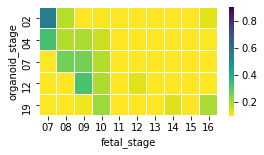

In [338]:
sn.heatmap(mean_prob_df, vmin=0.1, vmax=0.9, cmap="viridis_r", linewidths=0.01)

### proportion

In [431]:
mean_prop_df = (
    pd.concat(
        [
            pd.melt(fsk2org_predictions[ct]["prop"].reset_index(), id_vars=["annot_timepoint"])
            .assign(celltype=ct)
            .astype({"annot_timepoint": str})
            .replace(regex={f"(fetal|organoid)_{ct}, 0": ""})
            for ct in ct_shared_by_fsk_org  # if ct not in ["Adipocyte"]
        ]
    )
    .rename(
        columns={
            "annot_timepoint": "organoid_stage",
            "col_0": "fetal_stage",
            "value": "probability",
        }
    )
    .groupby(["organoid_stage", "fetal_stage"])
    .mean()
    .reset_index()
    .pivot(index=["organoid_stage"], columns=["fetal_stage"])
    .droplevel(0, axis=1)
)

<AxesSubplot:xlabel='fetal_stage', ylabel='organoid_stage'>

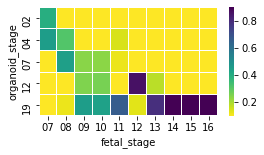

In [432]:
sn.heatmap(
    mean_prop_df / np.linalg.norm(mean_prop_df, ord=1, axis=0),
    vmin=0.1,
    vmax=0.9,
    cmap="viridis_r",
    linewidths=0.01,
)

<AxesSubplot:xlabel='fetal_stage', ylabel='organoid_stage'>

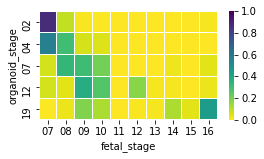

In [433]:
sn.heatmap(
    (mean_prop_df.T / np.linalg.norm(mean_prop_df.T, ord=1, axis=0)).T,
    vmin=0,
    vmax=1,
    cmap="viridis_r",
    linewidths=0.01,
)

In [436]:
mean_prop_jaccard = mean_prop_df / (
    np.tile(np.linalg.norm(mean_prop_df, ord=1, axis=0), 5).reshape((5, 10))
    + np.repeat(np.linalg.norm(mean_prop_df, ord=1, axis=1), 10).reshape((5, 10))
)

<AxesSubplot:xlabel='fetal_stage', ylabel='organoid_stage'>

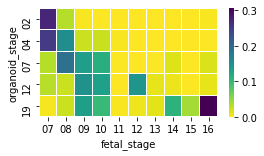

In [437]:
sn.heatmap(
    mean_prop_jaccard,
    # vmin=0,
    # vmax=1,
    cmap="viridis_r",
    linewidths=0.01,
)

## between stages including adult

In [5]:
pooled_ad0 = anndata.AnnData(
    **sk.read_h5ad(
        "h5ad/pooled_fetal_organoid_adult.processed.h5ad", component=["X", "obs", "var", "obsm"]
    )
)

In [6]:
pb_annot_pca = sk.pseudo_bulk(pooled_ad0, groupby="annot", use_rep="X_pca_project", FUN=np.median).T

In [7]:
annot_dist_df = pd.DataFrame(
    scipy.spatial.distance_matrix(pb_annot_pca.values, pb_annot_pca.values),
    index=pb_annot_pca.index,
    columns=pb_annot_pca.index,
)

In [8]:
ct_shared_by_all = (
    annot_dist_df.index.to_series()
    .str.partition("_", expand=True)[2]
    .value_counts()
    .where(lambda x: x == 3)
    .dropna()
    .index
)

In [9]:
pooled_ad0.obs["annot_timepoint"] = (
    pooled_ad0.obs.annot.astype(str) + ", " + pooled_ad0.obs.pcw.apply(lambda x: f"{x:03d}")
)
pooled_ad0.obs["annot_timepoint"] = pooled_ad0.obs["annot_timepoint"].astype("category")

In [205]:
fask_models = {}
fask2org_predictions = {}
for ct in ct_shared_by_all:
    fask_ad = pooled_ad0[
        (pooled_ad0.obs.dataset != "organoid") & (pooled_ad0.obs.annot.str.endswith(ct))
    ]
    org_ad = pooled_ad0[
        (pooled_ad0.obs.dataset == "organoid") & (pooled_ad0.obs.annot.str.endswith(ct))
    ]
    model_pkl = f"LR_models/fetal_adult_{ct.replace(' ', '-')}_by_timepoint.lognorm.pkl"
    if os.path.exists(model_pkl):
        lr = joblib.load(model_pkl)
    else:
        lr = sk.LR_train(
            fask_ad,
            groupby="annot_timepoint",
            use_rep="X",
            downsample_to=(200, "tmp.h5ad"),
            save=model_pkl,
        )
    fask_models[ct] = lr
    pred = sk.LR_predict(
        org_ad, lr, use_rep="X", return_predict=True, key_added="fask_annot_timepoint"
    )
    prob_df = pd.DataFrame(
        npg.aggregate_np(
            org_ad.obs.annot_timepoint.cat.codes,
            pred["prob"].values,
            func=np.median,
            axis=0,
        ),
        index=org_ad.obs.annot_timepoint.cat.categories,
        columns=pred["prob"].columns,
    )
    prop_df = pd.crosstab(org_ad.obs.annot_timepoint, org_ad.obs.fask_annot_timepoint)
    jaccard_df = sk.cross_table(
        org_ad, "annot_timepoint", "fask_annot_timepoint", normalise="jaccard"
    )
    fask2org_predictions[ct] = {"prob": prob_df, "prop": prop_df, "jaccard": jaccard_df}

46794 features used for prediction
Trying to set attribute `.obs` of view, copying.
46794 features used for prediction
Trying to set attribute `.obs` of view, copying.
46794 features used for prediction
Trying to set attribute `.obs` of view, copying.
46794 features used for prediction
Trying to set attribute `.obs` of view, copying.
46794 features used for prediction
Trying to set attribute `.obs` of view, copying.
46794 features used for prediction
Trying to set attribute `.obs` of view, copying.


In [206]:
gc.collect()

195755

In [148]:
org_ad.obs.fask_annot_timepoint.unique()

['adult_Melanocyte, 999', 'fetal_Melanocyte, 016', 'fetal_Melanocyte, 008', 'fetal_Melanocyte, 007', 'fetal_Melanocyte, 011', 'Uncertain', 'fetal_Melanocyte, 009']
Categories (7, object): ['adult_Melanocyte, 999', 'fetal_Melanocyte, 016', 'fetal_Melanocyte, 008', 'fetal_Melanocyte, 007', 'fetal_Melanocyte, 011', 'Uncertain', 'fetal_Melanocyte, 009']

In [136]:
ct = "Fibroblast"

In [156]:
(
    fask2org_predictions[ct]["prob"]
    / np.linalg.norm(fask2org_predictions[ct]["prob"], ord=1, axis=0)
).rename(index=lambda x: x.split(", ")[1], columns=lambda x: x.split(", ")[1]).sort_index(
    axis=1
).rename(
    index=lambda x: x.lstrip("0"),
    columns=lambda x: x.lstrip("0").replace("999", "Adult"),
)

,7,8,9,11,12,13,14,15,16,Adult
2,0.457538,0.291548,0.042393,0.218849,0.135508,0.171223,0.019956,0.107582,0.390035,0.011842
4,0.401176,0.303143,0.106259,0.323127,0.061965,0.128452,0.008145,0.012161,0.073138,0.028467
7,0.059168,0.268562,0.265696,0.181467,0.174528,0.255478,0.377780,0.170296,0.146579,0.200876
12,0.072759,0.111693,0.501406,0.241086,0.440921,0.234537,0.061516,0.230540,0.155062,0.258735
19,0.009359,0.025054,0.084246,0.035471,0.187078,0.210310,0.532602,0.479422,0.235187,0.500080


In [171]:
fask2org_predictions[ct]["prob"]

,7,8,9,10,11,12,13,14,15,16,Adult
2,0.223539,0.231307,0.074680,0.311716,0.004276,0.002379,0.000705,0.000411,0.004452,0.008066,0.064124
4,0.132609,0.155140,0.107273,0.487338,0.017303,0.001122,0.000838,0.000066,0.000481,0.000397,0.044457
7,0.060404,0.204888,0.110686,0.457792,0.009207,0.000904,0.000973,0.002287,0.002163,0.000645,0.049375
12,0.035077,0.063218,0.155314,0.460793,0.017902,0.004569,0.001255,0.000665,0.004154,0.001437,0.112913
19,0.016011,0.050018,0.093923,0.434838,0.008306,0.001110,0.003308,0.006048,0.008958,0.003564,0.249286


In [168]:
fask2org_predictions[ct]["jaccard"]

fask_annot_timepoint,Uncertain,"adult_Mural cell, 999","fetal_Mural cell, 007","fetal_Mural cell, 008","fetal_Mural cell, 009","fetal_Mural cell, 010","fetal_Mural cell, 012","fetal_Mural cell, 015"
annot_timepoint,,,,,,,,
"organoid_Mural cell, 002",0.0377,0.0110,0.0370,0.1356,0.0000,0.0185,0.000,0.0000
"organoid_Mural cell, 004",0.0233,0.0000,0.0625,0.0182,0.0000,0.0150,0.000,0.0000
"organoid_Mural cell, 007",0.0508,0.0000,0.0169,0.1289,0.0565,0.2096,0.000,0.0000
"organoid_Mural cell, 012",0.0435,0.0659,0.0025,0.0183,0.1405,0.4336,0.005,0.0000
"organoid_Mural cell, 019",0.0100,0.2010,0.0000,0.0142,0.0576,0.1847,0.000,0.0059


In [169]:
fask2org_predictions[ct]["jaccard"].rename(columns={"Uncertain": ", Uncertain"}).rename(
    index=lambda x: x.split(", ")[1], columns=lambda x: x.split(", ")[1]
).sort_index(axis=1).rename(
    index=lambda x: x.lstrip("0"),
    columns=lambda x: x.lstrip("0").replace("999", "Adult"),
)

fask_annot_timepoint,7,8,9,10,12,15,Adult,Uncertain
annot_timepoint,,,,,,,,
2,0.0370,0.1356,0.0000,0.0185,0.000,0.0000,0.0110,0.0377
4,0.0625,0.0182,0.0000,0.0150,0.000,0.0000,0.0000,0.0233
7,0.0169,0.1289,0.0565,0.2096,0.000,0.0000,0.0000,0.0508
12,0.0025,0.0183,0.1405,0.4336,0.005,0.0000,0.0659,0.0435
19,0.0000,0.0142,0.0576,0.1847,0.000,0.0059,0.2010,0.0100


In [207]:
for ct in ct_shared_by_all:
    for dtyp in ("prob", "prop", "jaccard"):
        fask2org_predictions[ct][dtyp] = (
            fask2org_predictions[ct][dtyp]
            .rename(columns={"Uncertain": ", Uncertain"})
            .rename(index=lambda x: x.split(", ")[1], columns=lambda x: x.split(", ")[1])
            .sort_index(axis=1)
            .rename(
                index=lambda x: x.lstrip("0"),
                columns=lambda x: x.lstrip("0").replace("999", "Adult"),
            )
        )

<AxesSubplot:xlabel='Fetal stage (post-conception week)', ylabel='Organoid stage\n(week)'>

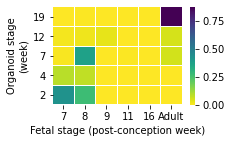

In [178]:
stage_align_heatmap(fask2org_predictions[ct]["jaccard"])

<AxesSubplot:xlabel='Fetal stage (post-conception week)', ylabel='Organoid stage\n(week)'>

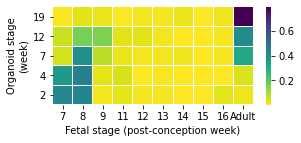

In [181]:
stage_align_heatmap(fask2org_predictions[ct]["prob"])

Text(0.5, 1.0, 'Melanocyte, Probability')

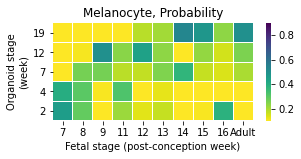

In [183]:
p1 = stage_align_heatmap(
    fask2org_predictions[ct]["prob"]
    / np.linalg.norm(fask2org_predictions[ct]["prob"], ord=1, axis=0),
    vmin=0.1,
    vmax=0.9,
)
p1.set_title(f"{ct}, Probability")

### probability

In [20]:
mean_prob_df = (
    pd.concat(
        [
            pd.melt(fask2org_predictions[ct]["prob"].reset_index(), id_vars=["index"])
            .assign(celltype=ct)
            .replace(regex={f"(fetal|organoid|adult)_{ct}, ": ""})
            for ct in ct_shared_by_all
        ]
    )
    .rename(columns={"index": "organoid_stage", "variable": "fetal_stage", "value": "probability"})
    .groupby(["organoid_stage", "fetal_stage"])
    .mean()
    .reset_index()
    .pivot(index=["organoid_stage"], columns=["fetal_stage"])
    .droplevel(0, axis=1)
)

In [193]:
mean_prob_df.index = ["2", "4", "7", "12", "19"]
mean_prob_df.columns = ["7", "8", "9", "10", "11", "12", "13", "14", "15", "16", "Adult"]

In [379]:
mean_prob_df

fetal_stage,007,008,009,010,011,012,013,014,015,016,999
organoid_stage,,,,,,,,,,,
002,0.563490,0.228840,0.028880,0.085154,0.008738,0.003910,0.003448,0.001956,0.009222,0.029316,0.031680
004,0.376609,0.251997,0.073605,0.160030,0.034808,0.003662,0.003861,0.003419,0.001790,0.012280,0.043082
007,0.051766,0.297647,0.120778,0.210073,0.022129,0.006589,0.016027,0.030474,0.006087,0.012568,0.191616
012,0.063959,0.085765,0.155794,0.215146,0.022626,0.040760,0.020304,0.006878,0.016060,0.018660,0.272066
019,0.015446,0.047006,0.059401,0.185679,0.012754,0.011784,0.032462,0.040423,0.039847,0.050256,0.435259


In [227]:
mean_prob_jaccard = mean_prob_df / (
    np.tile(np.linalg.norm(mean_prob_df, ord=1, axis=0), 5).reshape((5, 11))
    + np.repeat(np.linalg.norm(mean_prob_df, ord=1, axis=1), 11).reshape((5, 11))
    - mean_prob_df
)

### proportion

In [54]:
mean_prop_df = (
    pd.concat(
        [
            pd.melt(fask2org_predictions[ct]["prop"].reset_index(), id_vars=["annot_timepoint"])
            .assign(celltype=ct)
            .astype({"annot_timepoint": str})
            .replace(regex={f"(fetal|organoid|adult)_{ct}, ": ""})
            for ct in ct_shared_by_all  # if ct not in ["Adipocyte"]
        ]
    )
    .rename(
        columns={
            "annot_timepoint": "organoid_stage",
            "col_0": "fetal_stage",
            "value": "probability",
        }
    )
    .groupby(["organoid_stage", "fetal_stage"])
    .mean()
    .reset_index()
    .pivot(index=["organoid_stage"], columns=["fetal_stage"])
    .droplevel(0, axis=1)
)

In [64]:
mean_prop_df.index = ["2", "4", "7", "12", "19"]
mean_prop_df.columns = ["7", "8", "9", "10", "11", "12", "13", "14", "15", "16", "Adult"]

In [65]:
mean_prop_jaccard = mean_prop_df / (
    np.tile(np.linalg.norm(mean_prop_df, ord=1, axis=0), 5).reshape((5, 11))
    + np.repeat(np.linalg.norm(mean_prop_df, ord=1, axis=1), 11).reshape((5, 11))
    - mean_prop_df
)

### plot

In [225]:
def stage_align_heatmap(df, label=None, save=None, **kwargs):
    df1 = df.drop(columns=["Uncertain"]) if "Uncertain" in df.columns else df
    nrow, ncol = df1.shape
    ax = sk.heatmap(
        df1,
        cmap="viridis_r",
        figsize=(0.4 * ncol + 0.5, 0.3 * (nrow + 1)),
        **kwargs,
    )
    ax.invert_yaxis()
    ax.set_xlabel("Fetal stage (post-conception week)")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    ax.set_ylabel("Organoid stage\n(week)")
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    ax.axvline(x=ncol - 1, c="k", linewidth=0.5)

    fig = ax.get_figure()

    if label:
        fig.axes[1].set_ylabel(label)

    if save:
        fig.savefig(fname=save, bbox_inches="tight")

    return ax

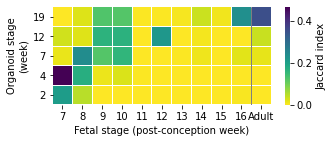

In [226]:
stage_align_heatmap(mean_prop_jaccard, label="Jaccard index");

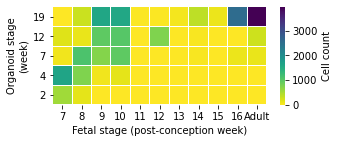

In [105]:
stage_align_heatmap(mean_prop_df, label="Cell count");

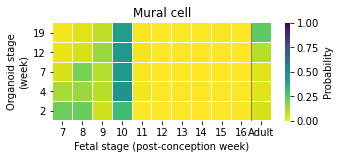

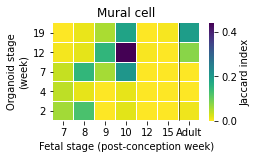

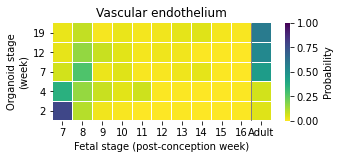

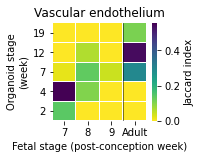

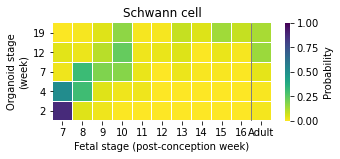

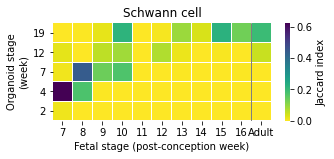

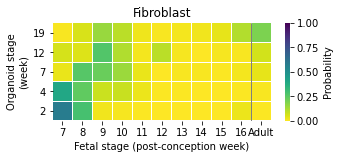

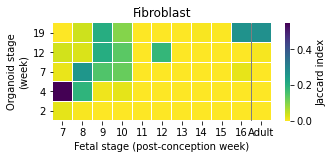

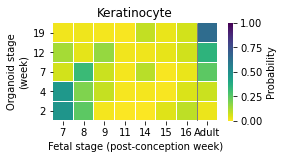

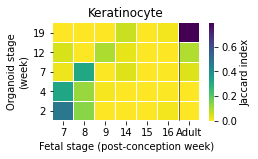

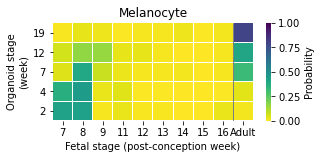

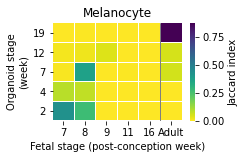

In [234]:
with PdfPages(filename="fsk_org_similarity_by_stage_by_compartment.20221012.pdf") as pdf:
    for ct in ct_shared_by_all:
        p1 = stage_align_heatmap(
            fask2org_predictions[ct]["prob"],
            # / np.linalg.norm(fask2org_predictions[ct]["prob"], ord=1, axis=0),
            label="Probability",
            vmin=0,
            vmax=1,
        )
        # p1.axvline(x=fask2org_predictions[ct]["prob"].shape[1] - 1, c="k")
        p1.set_title(ct)
        pdf.savefig(p1.get_figure(), bbox_inches="tight")
        plt.show()

        # p2 = stage_align_heatmap(
        #     fask2org_predictions[ct]["prop"]
        #     / np.linalg.norm(fask2org_predictions[ct]["prop"], ord=1, axis=1)[:, np.newaxis],
        #     label="Proportion",
        # )
        # p2.set_title(ct)
        # pdf.savefig(p2.figure, bbox_inches="tight")
        # plt.show()

        p3 = stage_align_heatmap(fask2org_predictions[ct]["jaccard"], label="Jaccard index")
        p3.set_title(ct)
        # p3.axvline(x=fask2org_predictions[ct]["jaccard"].shape[1] - 2, c="k")
        pdf.savefig(p3.figure, bbox_inches="tight")
        plt.show()

In [235]:
!rclone copy --drive-shared-with-me fsk_org_similarity_by_stage_by_compartment.20221012.pdf "google:/Fetal Skin/Figures/Figs_from_Ni/"

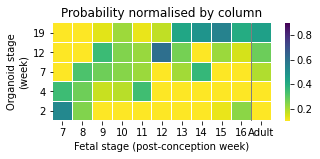

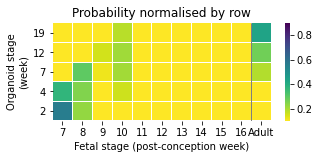

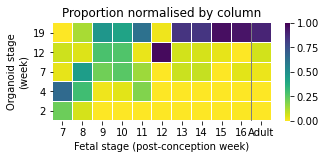

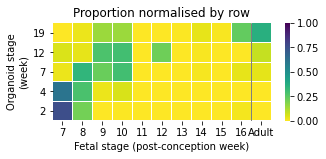

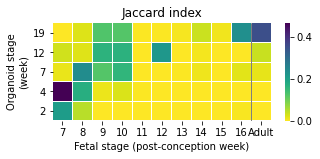

In [232]:
sk.set_figsize((4, 2))
with PdfPages(
    filename="fsk_org_similarity_by_stage_average_across_compartment.20221011.pdf"
) as pdf:
    p1 = stage_align_heatmap(
        mean_prob_df / np.linalg.norm(mean_prob_df, ord=1, axis=0),
        vmin=0.1,
        vmax=0.9,
    )
    p1.set_title("Probability normalised by column")
    pdf.savefig(p1.get_figure(), bbox_inches="tight")
    plt.show()

    p2 = stage_align_heatmap(mean_prob_df, vmin=0.1, vmax=0.9)
    p2.set_title("Probability normalised by row")
    pdf.savefig(p2.get_figure(), bbox_inches="tight")
    plt.show()

    # p3 = stage_align_heatmap(mean_prob_jaccard)
    # p3.set_title("Probability-derived jaccard index")
    # pdf.savefig(p3.get_figure(), bbox_inches="tight")
    # plt.show()

    p4 = stage_align_heatmap(
        mean_prop_df / np.linalg.norm(mean_prop_df, ord=1, axis=0), vmin=0, vmax=1
    )
    p4.set_title("Proportion normalised by column")
    pdf.savefig(p4.get_figure(), bbox_inches="tight")
    plt.show()

    p5 = stage_align_heatmap(
        (mean_prop_df.T / np.linalg.norm(mean_prop_df.T, ord=1, axis=0)).T, vmin=0, vmax=1
    )
    p5.set_title("Proportion normalised by row")
    pdf.savefig(p5.get_figure(), bbox_inches="tight")
    plt.show()

    p6 = stage_align_heatmap(mean_prop_jaccard)
    p6.set_title("Jaccard index")
    pdf.savefig(p6.get_figure(), bbox_inches="tight")
    plt.show()

In [233]:
!rclone copy --drive-shared-with-me fsk_org_similarity_by_stage_average_across_compartment.20221011.pdf "google:/Fetal Skin/Figures/Figs_from_Ni/"

# LR based on PCs

In [278]:
ask_lr = sk.LR_train(
    pooled_ad0[pooled_ad0.obs.dataset == "adult"],
    groupby="annot",
    use_rep="X_pca_project",
    save="adult.pooled_fsk_ask_org.pca_projection.LR.pkl",
)

In [ ]:
fsk_lr = sk.LR_train(
    pooled_ad0[pooled_ad0.obs.dataset == "fetal"],
    groupby="annot",
    use_rep="X_pca_project",
    save="fetal.pooled_fsk_adt_org.pca_projection.LR.pkl",
)

In [ ]:
org_lr = sk.LR_train(
    pooled_ad0[pooled_ad0.obs.dataset == "organoid"],
    groupby="annot",
    use_rep="X_pca_project",
    save="organoid.pooled_fsk_adt_org.pca_projection.LR.pkl",
)

In [289]:
fsk_pred = sk.LR_predict(
    pooled_ad0, fsk_lr, use_rep="X_pca_project", key_added="fsk_annot_pca", return_predict=True
)
ask_pred = sk.LR_predict(
    pooled_ad0, ask_lr, use_rep="X_pca_project", key_added="ask_annot_pca", return_predict=True
)
org_pred = sk.LR_predict(
    pooled_ad0, org_lr, use_rep="X_pca_project", key_added="org_annot_pca", return_predict=True
)

30 features used for prediction
30 features used for prediction
30 features used for prediction


In [336]:
fsk_pred_df = pd.DataFrame(
    npg.aggregate_np(
        pooled_ad0.obs.annot.cat.codes, fsk_pred["prob"].values, func=np.median, axis=0
    ),
    index=pooled_ad0.obs.annot.cat.categories,
    columns=fsk_pred["prob"].columns,
)

In [337]:
ask_pred_df = pd.DataFrame(
    npg.aggregate_np(
        pooled_ad0.obs.annot.cat.codes, ask_pred["prob"].values, func=np.median, axis=0
    ),
    index=pooled_ad0.obs.annot.cat.categories,
    columns=ask_pred["prob"].columns,
)

In [338]:
org_pred_df = pd.DataFrame(
    npg.aggregate_np(
        pooled_ad0.obs.annot.cat.codes, org_pred["prob"].values, func=np.median, axis=0
    ),
    index=pooled_ad0.obs.annot.cat.categories,
    columns=org_pred["prob"].columns,
)

In [299]:
fsk_pred_df.shape, ask_pred_df.shape, org_pred_df.shape

((50, 25), (50, 15), (50, 10))

In [339]:
pred_prob_df = pd.concat([fsk_pred_df, ask_pred_df, org_pred_df], axis=1)

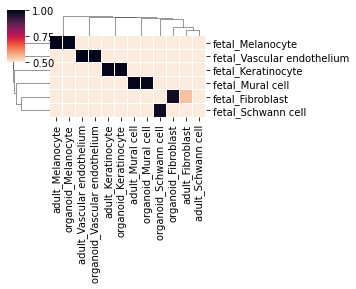

In [345]:
sn.clustermap(
    pred_prob_df.loc[
        (
            ~pred_prob_df.columns.str.startswith("fetal_")
            & pred_prob_df.columns.to_series().str.partition("_")[2].isin(ct_shared_by_all)
        ),
        (
            pred_prob_df.index.str.startswith("fetal_")
            & pred_prob_df.index.to_series().str.partition("_")[2].isin(ct_shared_by_all)
        ),
    ].T,
    cmap="rocket_r",
    linewidth=0.01,
    vmin=0.5,
    vmax=1,
    figsize=(5, 4),
);

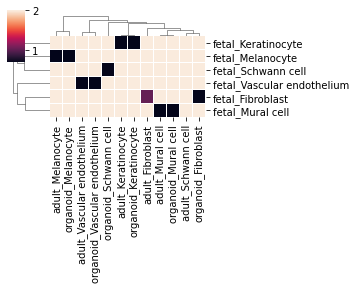

In [362]:
sn.clustermap(
    np.log1p(
        1
        / fsk_pred_df.loc[
            ~pred_prob_df.columns.str.startswith("fetal_")
            & pred_prob_df.columns.to_series().str.partition("_")[2].isin(ct_shared_by_all),
            pred_prob_df.index.str.startswith("fetal_")
            & pred_prob_df.index.to_series().str.partition("_")[2].isin(ct_shared_by_all),
        ].T
    ),
    cmap="rocket",
    vmax=2,
    linewidth=0.01,
    figsize=(5, 4),
)

In [363]:
fsk_pred_df.loc[
    ~pred_prob_df.columns.str.startswith("fetal_")
    & pred_prob_df.columns.to_series().str.partition("_")[2].isin(ct_shared_by_all),
    pred_prob_df.index.str.startswith("fetal_")
    & pred_prob_df.index.to_series().str.partition("_")[2].isin(ct_shared_by_all),
].T

,adult_Fibroblast,adult_Keratinocyte,adult_Melanocyte,adult_Mural cell,adult_Schwann cell,adult_Vascular endothelium,organoid_Fibroblast,organoid_Keratinocyte,organoid_Melanocyte,organoid_Mural cell,organoid_Schwann cell,organoid_Vascular endothelium
fetal_Fibroblast,5.540907e-01,1.473303e-07,2.349173e-12,9.406077e-04,1.472414e-01,1.693913e-12,9.747086e-01,1.423099e-07,2.029920e-14,2.866644e-03,3.281600e-08,3.039591e-14
fetal_Keratinocyte,4.604536e-10,9.999236e-01,9.196503e-12,3.535689e-09,5.965603e-07,2.649612e-11,3.319150e-07,9.999112e-01,1.572784e-13,5.574721e-09,1.110625e-10,2.614621e-13
fetal_Melanocyte,3.292455e-10,3.861036e-08,9.999683e-01,1.308163e-08,9.365290e-07,2.659217e-10,1.285796e-07,3.105025e-08,9.999988e-01,2.473381e-08,3.923050e-07,9.903476e-12
fetal_Mural cell,2.061452e-07,8.424997e-11,8.884739e-14,9.964567e-01,2.178474e-03,6.517423e-07,3.783511e-05,5.501316e-11,6.123238e-16,9.912223e-01,3.103822e-11,1.417050e-07
fetal_Schwann cell,4.812858e-10,1.077354e-08,8.178404e-09,1.620326e-08,1.546012e-05,3.153635e-10,1.255182e-07,8.318805e-10,8.381622e-11,7.647957e-09,9.789360e-01,3.068671e-12
fetal_Vascular endothelium,2.993432e-09,9.151056e-09,5.238904e-14,1.730200e-08,8.748783e-06,9.999597e-01,2.668673e-06,9.329031e-09,2.399203e-16,3.279876e-08,9.427173e-10,9.999976e-01


In [ ]:
sn.clustermap(pred_prob_df, cmap="rocket_r", linewidth=0.01, figsize=(15, 15))